In [ ]:
#install necessary packages
%pip install scikit-learn --upgrade
%pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import basic functions and set up functions used throughout notebook. 

import os
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/cook_adjacency/'

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from functools import reduce
import glob
import networkx as nx
import re
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from itertools import product
import matplotlib.colors
from scipy import stats
from scipy.special import expit


def brittin_layers(n):
  #requires passing nclass first
  if n in ('CEPV', 'URY', 'URA', 'URA', 'RME', 'RIP', 'OLQ', 'IL2', 'IL1', 
           'URY', 'IL1', 'RMDD', 'RMDV', 'OLL', 'RIH', 'AVE', 'RIA'
  ):
    return 'Anterior'
  if n in ('FLP', 'ADA', 'ASH', 'RIF', 'PVP', 'PVC', 'BDU', 'AVM', 'AVJ', 'AVH', 'AVD', 'AVB', 'ALM', 'AQR'
  ):
    return 'Avoidance'
  if n in ('DVC', 'RIG', 'RIS', 'SMD', 'RIV', 'SAA', 'PVT', 'AVK', 'AVL', 'RMF', 'RIM'
  ):
    return 'Lateral'
  if n in ('RMG', 'CEPD', 'URB', 'DVA', 'SMB', 'SIA', 'SIBV', 'SIBD', 'RIC', 'SDQ', 'RMH'
  ):
    return 'Sublateral'
  if n in ('BAG', 'RIB', 'ASI', 'AWC', 'AIN', 'AUA', 'AFD', 'AIY', 'ADL', 'AWB', 'ASE', 'AWA', 'ADF', 'AIZ', 'AIB', 'AIA', 'ASG', 'ASK', 'AVF', 'PVQ', 'ASJ', 'AIM', 'ALA'
  ):
    return 'Taxis'
  if n in ('RMD', 'URX', 'ALN', 'ADE', 'AVA', 'RIR', 'RID', 'HSN', 'PVR', 'PVN', 'PLN'
  ):
    return 'Unclassified'
  else:
    return 'non-ganglia'


def moyle_layers(n):
  if n in ('CEPV', 'CEPD', 'IL1', 'IL2', 'OLL', 'OLQ', 'RIA', 'RIH', 'RIP', 'RMDV', 'RMDD', 'RME', 'URA', 'URB', 'URY'
  ):
    return 'Stratum1'
  if n in ('ADE', 'ALN', 'AVK', 'AVL', 'DVC', 'PLN', 'PVT', 'RIC', 'RIV', 'RMD', 'RMF', 'RMH', 'SAA', 'SIA', 'SIBD', 'SMB', 'SMD'
  ):
    return 'Stratum2'
  if n in ('ADA', 'ADL', 'AIM', 'ALA', 'ALM', 'AQR', 'ASH', 'ASJ', 'ASK', 'AVB', 'AVD', 'AVF', 'AVH', 'AVJ', 'AVM', 'BDU', 'DVA', 'HSN', 'PVC', 'PVN', 'PVP', 'PVQ', 'RID', 'RIF'
  ):
    return 'Stratum3'
  if n in ('ADF', 'AFD', 'AIA', 'AIN', 'AIY', 'ASE', 'ASG', 'ASI', 'AUA', 'AWB', 'AWC', 'BAG'
  ):
    return 'Stratum4'
  if n in ('AIB', 'AIZ', 'AVA', 'AVE', 'AWA', 'FLP', 'PVR', 'RIB', 'RIG', 'RIM', 'RIR', 'RIS', 'RMG', 'SDQ', 'SIBV', 'URX', 'VB0'
  ):
    return 'Unassigned'
  else:
    return 'non-ganglia'

def ganglia_check(i,j):
  if (i == 'non-ganglia') | (j == 'non-ganglia'):
     return '0'
  if i == j:
    return '1'
  else:
    return '2'

#nclass and other functions originally published in Witvliet et al 2021, available on https://github.com/dwitvliet/nature2021

def nclass_strata(n):
  #deals with CEP,RMD,SIB to give 4 letter clasifications as per Moyle, Brittin, and ganglia differences
    if n in (
        'AVG', 'DVC', 'PVR', 'PVT', 'RIH', 'RIR', 'DVA', 'AQR', 'AVM', 'PQR',
        'PVM', 'DVB', 'PDA', 'PDB', 'ALA', 'AVL', 'RID', 'RIS',
        'I3', 'I4', 'I5', 'I5', 'M1', 'M4', 'M5', 'MI', 'BWM'
    ):
        return n
    if len(n) == 4 and n[-1] in 'LR' and n[:3] in (
        'ADA', 'ADE', 'ADF', 'ADL', 'AFD', 'AIA', 'AIB', 'AIM', 'AIN', 'AIY',
        'AIZ', 'ALM', 'ALN', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK', 'AUA',
        'AVA', 'AVB', 'AVD', 'AVE', 'AVF', 'AVH', 'AVJ', 'AVK', 'AWA', 'AWB',
        'AWC', 'BAG', 'BDU', 'CAN', 'FLP', 'GLR', 'HSN', 'IL1', 'IL2', 'LUA',
        'OLL', 'PDE', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PVC', 'PVD', 'PVN',
        'PVP', 'PVQ', 'PVW', 'RIA', 'RIB', 'RIC', 'RIF', 'RIG', 'RIM', 'RIP',
        'RIV', 'RMD', 'RMF', 'RMG', 'RMH', 'SDQ', 'URB', 'URX'
    ):
        return n[:3]
    if len(n) == 5 and n[-2:] in ('DL', 'DR', 'VL', 'VR') and n[:3] in (
        'GLR', 'IL1', 'IL2', 'OLQ', 'SAA', 'SIA', 'SMB',
        'SMD', 'URA', 'URY'
    ):
        return n[:3]
    if len(n) == 5 and n[-2:] in ('DL', 'DR', 'VL', 'VR') and n[:3] in (
        'CEP', 'RMD', 'SIB', 
 
    ):
        return n[:4]
    if len(n) == 8 and re.match('BWM-[DV][LR]0[0-8]', n):
        return 'BWM'
    if n in (
        'RMED', 'RMEL', 'RMER', 'RMEV', 'SABD', 'SABVL', 'SABVR',
    ):
        return n[:3]
    if n in (
        'CEPshDL', 'CEPshDR', 'CEPshVL', 'CEPshVR'
    ):
        return n[:5]
    if n[:2] in ('AS', 'VB', 'VA', 'VD') and n[2:] in map(str, range(12)):
        return n[:2]
    if n in ('VA12', 'VD12', 'VD13'):
        return n[:2]
    if re.match('^(DA[1-9])|(DB[1-7])|(DD[1-6])|(VC[1-6])$', n):
        return n[:2]
    else:
        return 'unk'
    return n

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cook_adjacency


Cell to create composite edge lists for adjacency and connectivity. Needs to be run separately for adjacency and connectivity.



In [ ]:
#DO NOT RUN UNLESS NEEDED TO COMPARE EDGE LISTS##
#compare edges script. takes formatted edge lists and compares conserved and discrepant edges based up on a set of all edges within files. will take every .csv file in the directory#

#declare arguments for how to run subsequent code. Grouped variable can either be class (takes first three letters) or a specific grouping. if directed is true then will treat edges as directed

#choose directory from which to work. folders separated by adjacency, synapses, adult.
DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency/input/male_full/inputs/'

GROUPED = 'class'

#if directed is true then will treat edges as directed

DIRECTED = False

#set weight threshold for edges

W = float(0)

#set whether to keep or remove muscles

MUSCLE = 'blank'


#take a list of .csv files, apply filters, compose a networkx graph for each
os.chdir(DIRECTORY_CHOOSE)
csvfiles = []
csvfiles = [f for f in glob.glob('[!df"]*.csv')]
graphlist = []
for f in csvfiles:
	df = pd.read_csv(f, delimiter=',')
	df['weight'] = df['weight'].astype(float)
	if GROUPED == 'class':
		df['source']=df['source'].apply(str)
		df['target']=df['target'].apply(str)
		df['source'] = df.apply(lambda x: nclass_strata(x['source']), axis=1)
		df['target'] = df.apply(lambda x: nclass_strata(x['target']), axis=1)
		df = df.groupby(['source','target'], as_index=False)['weight'].sum()
	if DIRECTED != True:
		df[['source','target']] = np.sort(df[['source', 'target']])[:, ::1]
		df['weightyesno'] = np.where(df['weight'] > 0, 1, 0)
		df = df.groupby(['source','target'], as_index=False)['weight', 'weightyesno'].sum()
		df['reciprocal'] = np.where(df.weightyesno > 1, 'yes', 'no')
	if GROUPED != "class" and GROUPED != False:
		df = df[df.source.isin(eval(GROUPED))]
		df = df[df.target.isin(eval(GROUPED))]
		#df = df.groupby(['source','target'], as_index=False)['weight'].sum()
	if W > 0:
		df = df.drop(df[df.weight < W].index)
	if MUSCLE == 'remove':
		df = df[~df.source.str.contains('bwm', case=False)]
		df = df[~df.target.str.contains('bwm', case=False)]
	G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())
	if DIRECTED != True:
		G.to_undirected(reciprocal=False, as_view=False)
	G.name = str(f)
	graphlist.append(G)

inter = nx.compose_all(graphlist)
	
#append a dataframe with all graphlists

for i in graphlist:
	i.name = str(i)[15:]
	Z = []
	for (e1,e2) in inter.edges():
		if i.has_edge(e1,e2):
			Z.append([e1,e2,i[e1][e2]['weight']])
		if not i.has_edge(e1,e2):
			Z.append([e1,e2,0])
	dfz = pd.DataFrame(Z)
	dfz.columns = ['pre', 'post', i.name + "_weight"]
	dfz.to_csv(i.name + '_pd.csv', index=False) 
	dataframes = []
set_array = []
for f in sorted(glob.glob("*_pd.csv")):
	dfa = pd.read_csv(f, sep=',')
	dataframes.append(dfa)
	os.remove(f)
		
		
#create new columns
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='outer'), dataframes)
df_merged["conserved"] = (df_merged.filter(like="weight",axis=1)!=0).sum(1)
df_merged["average_size"] = (df_merged.sum(axis=1) - df_merged.conserved) / df_merged.conserved

#write to csv
df_merged.to_csv("df_merged_adult_syn_male_DIRECTED.csv")



FileNotFoundError: ignored

Main cell for generating model. Needs to be run before plotting.

In [ ]:


#recode function for how to deal with average synaptic size. 

def synapse_recode(X):
  if X > 0:
    return 1
  else:
    return 0

#import dfs from the compare syn and edge cell##
DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency/input/'
os.chdir(DIRECTORY_CHOOSE)
adj, syn = pd.read_csv('df_merged_adult_adj_ml_full.csv'), pd.read_csv('df_merged_adult_syn_ml_full.csv')
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), [adj,syn])
new_cols = ['jsh_adj', 'n2u_adj', 'witvliet_1_adj', 'witvliet_2_adj', 'witvliet_3_adj', 'witvliet_4_adj', 'witvliet_5_adj', 'witvliet_6_adj', 'witvliet_8_adj', 'jsh_syn', 'n2u_syn', 'witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'witvliet_7_syn', 'witvliet_8_syn']
df_merged.rename(columns=dict(zip(df_merged.columns[[3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24]], new_cols)),inplace=True)

#construct new columns to measure the average synaptic size. 
df_merged['new_ave_synapse'] = df_merged[['jsh_syn', 'n2u_syn', 'witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'witvliet_7_syn', 'witvliet_8_syn']].median(axis=1)
df_merged['dummy_size'] = df_merged['new_ave_synapse'].apply(synapse_recode)



#droplist includes SAB because Moyle and Brittin don't analyze. It's not a NR neuron. If a neuron is in one of two datasets, it becomes unclassified in the other.

droplist = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct']
df_merged = df_merged[~df_merged.pre.isin(droplist)]
df_merged = df_merged[~df_merged.post.isin(droplist)]


#scale and rename the adjacency columns
scaler = StandardScaler()
new_cols1 = ['jsh_adj-S', 'n2u_adj-S', 'witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'witvliet_8_adj-S']
df_scale = pd.DataFrame(scaler.fit_transform(df_merged.iloc[:,3:12]))
df_scale.rename(columns=dict(zip(df_scale.columns[[0,1,2,3,4,5,6,7,8]], new_cols1)),inplace=True)
df_scale['ave_scaled_adjacency'] = df_scale[['jsh_adj-S', 'n2u_adj-S', 'witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'witvliet_8_adj-S']].mean(axis=1)



#concatenate dfs
df_concat = pd.concat([df_merged, df_scale.set_index(df_merged.index)], axis=1)
df_concat['pre_brittin'] = df_concat.apply(lambda x: brittin_layers(x['pre']), axis=1)
df_concat['post_brittin'] = df_concat.apply(lambda x: brittin_layers(x['post']), axis=1)
df_concat['pre_moyle'] = df_concat.apply(lambda x: moyle_layers(x['pre']), axis=1)
df_concat['post_moyle'] = df_concat.apply(lambda x: moyle_layers(x['post']), axis=1)
df_concat['brittin_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_brittin'], x['post_brittin']), axis=1)
df_concat['moyle_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_moyle'], x['post_moyle']), axis=1)

#make dummy columns for the categorical predictors
categorical_cols = ['pre_brittin', 'post_brittin', 'pre_moyle', 'post_moyle', 'brittin_strata', 'moyle_strata']
df_concat[['brittin_bool_1', 'brittin_bool_2']] = pd.get_dummies(df_concat.brittin_strata, prefix='brittin')
df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
df_concat[['brittin_pre_class_1', 'brittin_pre_class_2', 'brittin_pre_class_3', 'brittin_pre_class_4', 'brittin_pre_class_5', 'brittin_pre_class_6']] = pd.get_dummies(df_concat.pre_brittin, prefix='brittin')
df_concat[['brittin_post_class_1', 'brittin_post_class_2', 'brittin_post_class_3', 'brittin_post_class_4', 'brittin_post_class_5', 'brittin_post_class_6']] = pd.get_dummies(df_concat.post_brittin, prefix='moyle')
df_concat.fillna(0, inplace=True) 

df_concat.to_csv('NR_modeling.csv')


#set variables for modeling
X_scale= df_concat[['ave_scaled_adjacency', 'brittin_bool_1', 'brittin_bool_2']]
Y = df_concat.dummy_size
Y.fillna(0, inplace=True)
Y = Y.astype('int')


# Y.hist(figsize=(12,8), bins=10)
# plt.show()

# matrix = X_scale.corr().round(2)
# sns.heatmap(matrix, annot=True)
# plt.show()



# Split 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X_scale, Y, test_size=0.25,random_state=42)






In [ ]:
###Cross validating the classifiers
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from matplotlib import pyplot as plt    
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate



mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=900,activation = 'logistic',solver='adam')
rf = RandomForestClassifier(n_estimators = 100, criterion='gini', verbose=0, random_state = np.random.RandomState(69), max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10)
x = XGBClassifier(eval_metric="auc", scale_pos_weight=25, early_stopping_rounds=10, enable_categorical=True, max_depth=9, min_child_weight=6, n_jobs = 8, n_estimators = 600, tree_method='exact', eta=0.5, verbosity = 0, learning_rate=0.0005, gamma=1.25, objective='reg:logistic', booster='dart')
clf = DecisionTreeClassifier(max_depth =5, random_state = 42, min_samples_leaf=5)
logreg = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
classifiers = [mlp, rf, x, clf, logreg]
names = ['Multi-layer Perceptron', 'Random Forest', 'XGBoost', 'Decision Tree', 'Logistic Regression']

smote_nc = SMOTENC(categorical_features=[1,2], random_state=1)
scores = {}
i = 0
for j in classifiers:
    pip = make_pipeline(smote_nc, j)
    cv = StratifiedKFold(n_splits=10)
    metrics = cross_validate(pip, X_train, y_train, scoring=('average_precision','roc_auc','f1'), cv=cv, return_train_score=True)
    roc = metrics['test_roc_auc']
    avg_precision = metrics['test_average_precision']
    f1 = metrics['test_f1']
    scores[names[i]] = [np.mean(roc), np.mean(avg_precision), np.mean(f1)]
    i += 1
scoresdf = pd.DataFrame.from_dict(scores)
scoresdf = scoresdf.set_index(pd.Index(['ROC_AUC', 'PR_AUC','F1'], name='Metric'))
scoresdf.to_csv('TableS1.csv')
scoresdf


,Multi-layer Perceptron,Random Forest,XGBoost,Decision Tree,Logistic Regression
Metric,,,,,
ROC_AUC,0.937677,0.904719,0.915541,0.923959,0.937307
PR_AUC,0.791273,0.698312,0.653441,0.703208,0.790901
F1,0.706423,0.677466,0.537986,0.709319,0.730453


In [ ]:
#hyperparameter tuning of logistic regression
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
#smote original training split including categorical
smote_nc = SMOTENC(categorical_features=[1,2], random_state=60)
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)




# smotedf = shuffle(smotedf, random_state=1)

#import GridseachCV
from sklearn.model_selection import GridSearchCV

#Instantiate
clf = LogisticRegression()

#Grid
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 2, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#Gridsearch
gridsearch = GridSearchCV(clf, parameter_grid)
gridsearch.fit(X_train_smote, y_train_smote);

#Get best hyperparameters
gridsearch.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

final logistic regression model results

Final statistics and plotting cell

logistic_regression
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       531
           1       0.68      0.81      0.74       140

    accuracy                           0.88       671
   macro avg       0.81      0.85      0.83       671
weighted avg       0.89      0.88      0.88       671

ROC-AUC is 0.940
PR-AUC is 0.764
intercept: [0.]
coefficient: [ 2.55293382  0.         -0.11984316]
filling fraction is 0.5232948192322028
[0.19585112873703478, 0.23664596273291927, 0.24180581323438466, 0.2413793103448276, 0.2918945798110393, 0.2966804979253112, 0.3659454374412041, 0.3957858769931663, 0.46373951652688705]
spearman's r for conserved_x and conserved_y 0.5788705167322703 6.879039522037795e-240
spearman's r for conserved_x and new_ave_synapse 0.4337401347440604 1.6447842377917217e-123
spearman's r for ave scaled adjacency and new_ave_synapse 0.6159480486206614 4.673346098883832e-280
pearson's r for ave scaled adjacency and new_ave_s

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


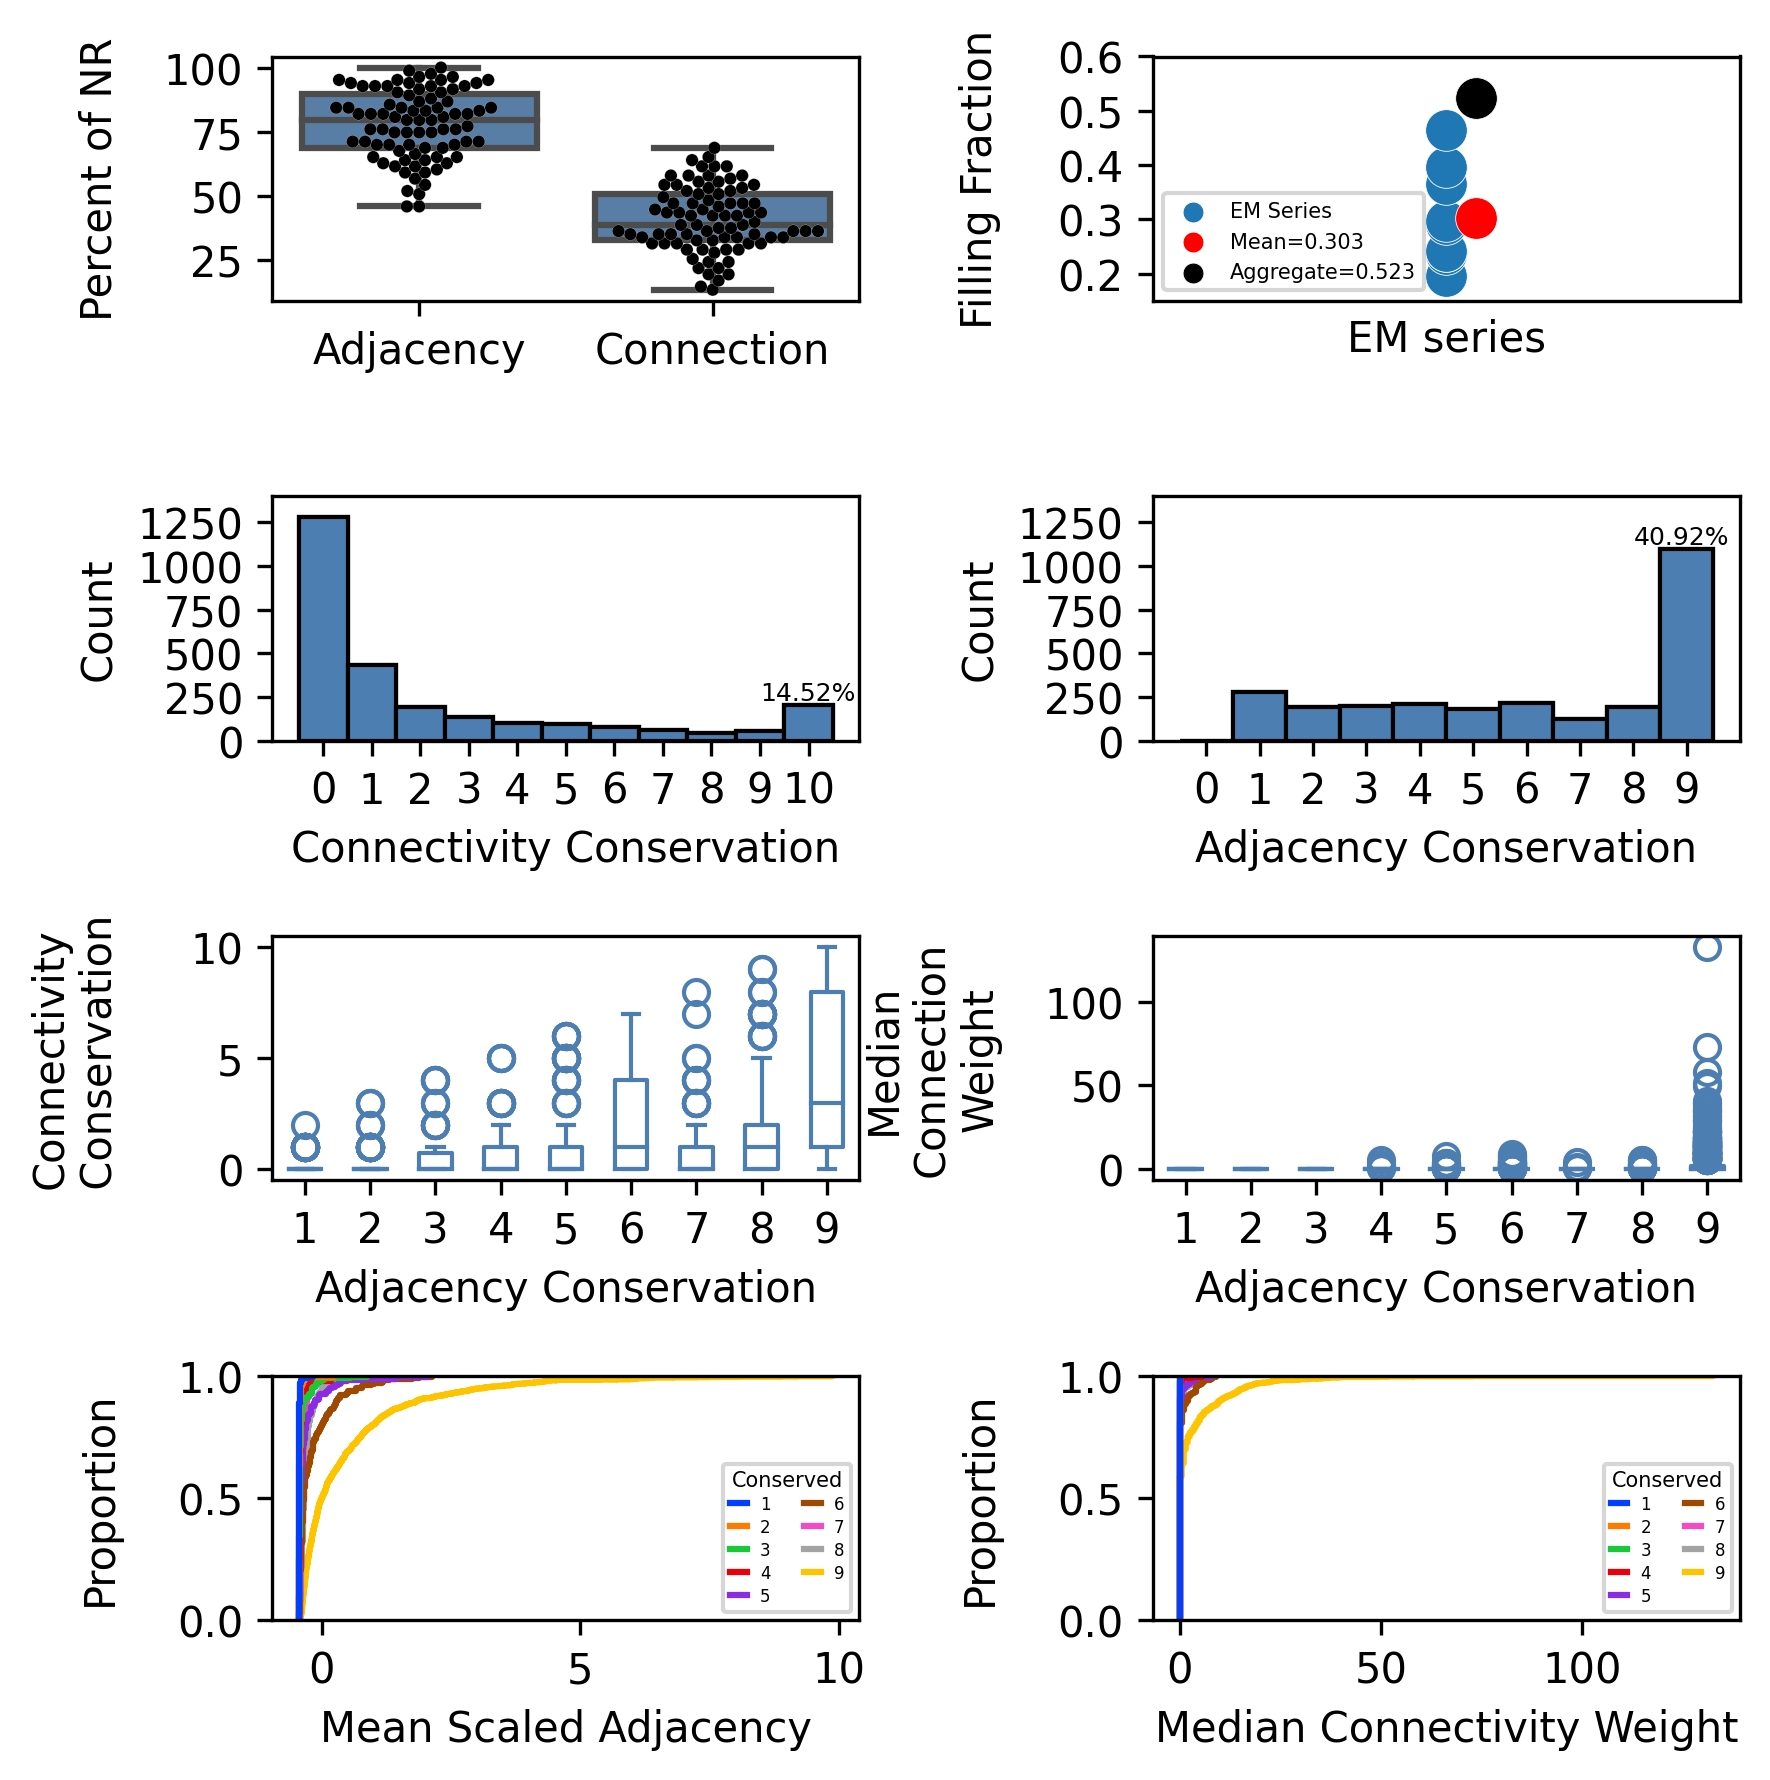

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<Figure size 432x288 with 0 Axes>

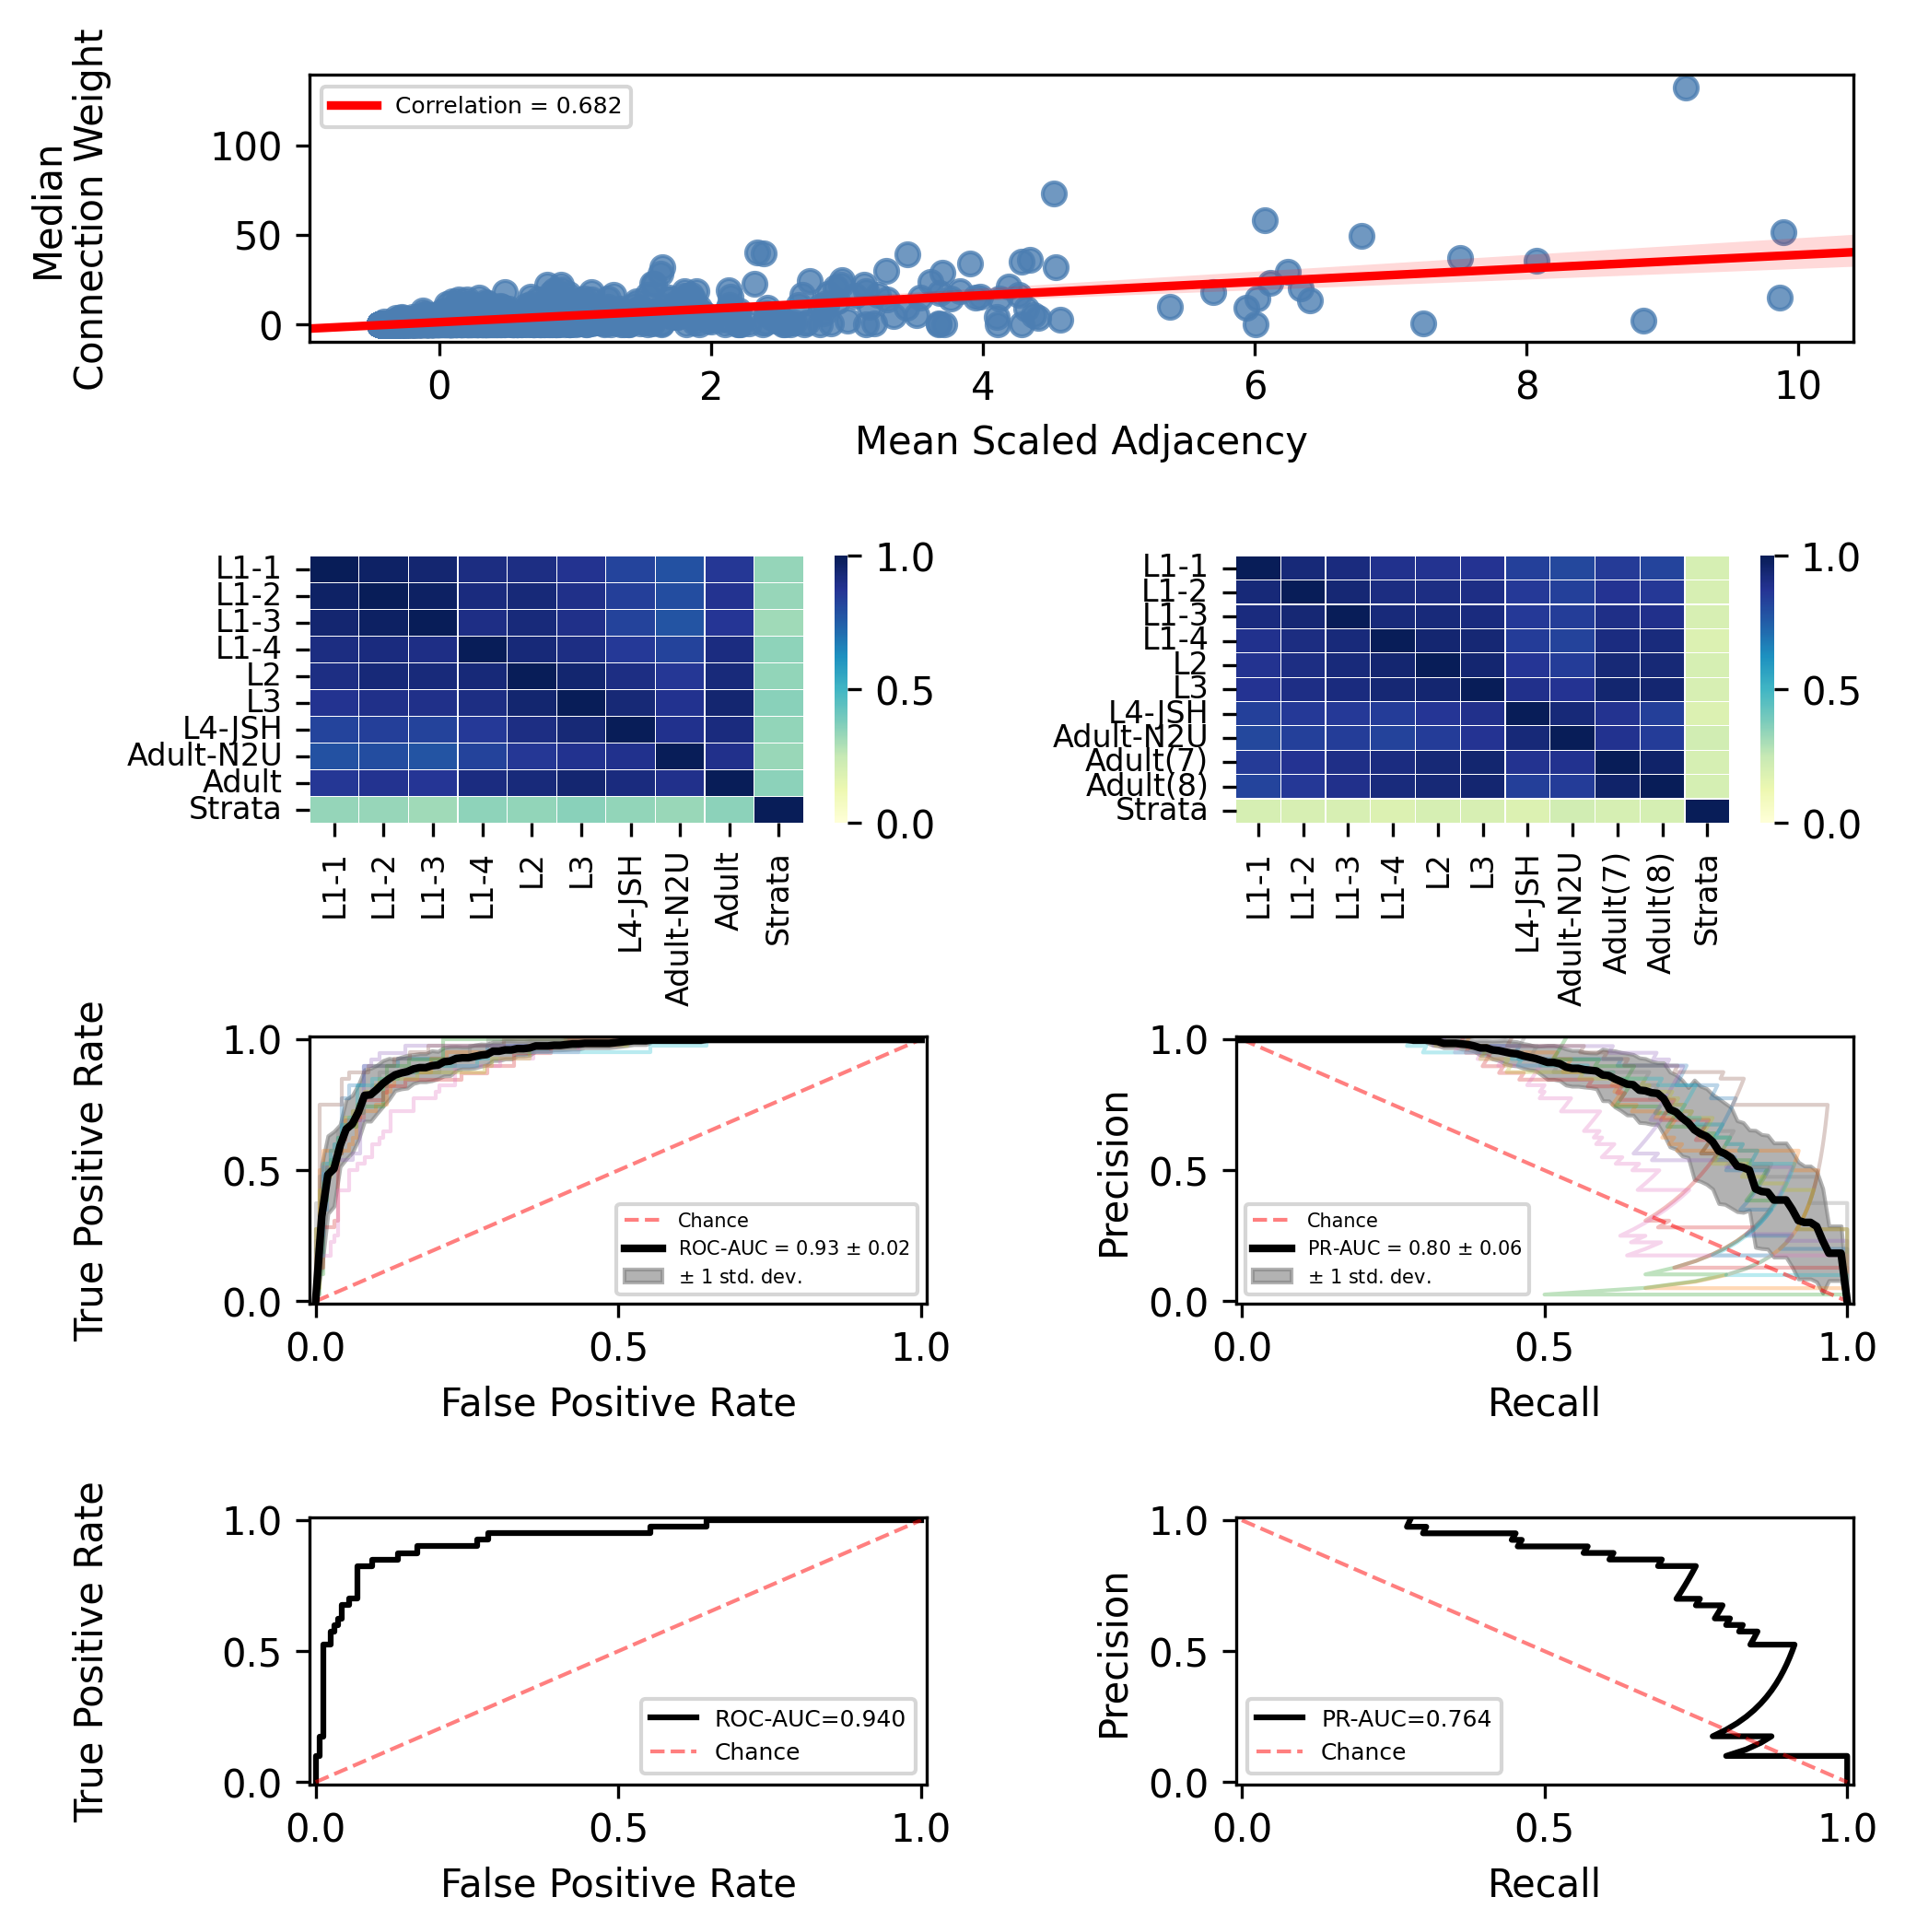

In [ ]:

from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt





print('logistic_regression')

logreg_final = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
logreg_final.fit(X_train_smote, y_train_smote)
log_predictions = logreg_final.predict(X_test)
print(classification_report(y_test,log_predictions))



y_pred_proba = logreg_final.predict_proba(X_test)[::,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
auc_ROC = str(metrics.roc_auc_score(y_test, y_pred_proba))[:5]
auc_precision_recall = str(metrics.auc(recall, precision))[:5]
print("ROC-AUC is", auc_ROC)
print("PR-AUC is", auc_precision_recall)
print('intercept:', logreg_final.intercept_)
print('coefficient:', logreg_final.coef_[0])






###calculate statistics###

##Filling Fraction Section####
filling_fraction = len(df_concat[df_concat.conserved_y > 0]) / len(df_concat.conserved_y)
filling_fraction_str = str(len(df_concat[df_concat.conserved_y > 0]) / len(df_concat.conserved_y))[:5]

print("filling fraction is", filling_fraction)


ff_list =  ['witvliet_1', 'witvliet_2', 'witvliet_3', 'witvliet_4', 'witvliet_5', 'witvliet_6', 'witvliet_8', 'jsh', 'n2u']

ff_values = []
for i in ff_list:
  syn_col = (i + '_syn')
  adj_col = (i + '_adj')
  value = len(df_concat[df_concat[syn_col] > 0]) / len(df_concat[df_concat[adj_col] > 0])
  ff_values.append(value)

print(ff_values)
ff_mean = str(np.mean(ff_values))[:5]
  


###correlations###
rho, pval = stats.spearmanr(df_concat.conserved_x, df_concat.conserved_y)
print("spearman's r for conserved_x and conserved_y", rho, pval)

rho, pval = stats.spearmanr(df_concat.conserved_x, df_concat.new_ave_synapse)
print("spearman's r for conserved_x and new_ave_synapse", rho, pval)

rho, pval = stats.spearmanr(df_concat.ave_scaled_adjacency, df_concat.new_ave_synapse)
print("spearman's r for ave scaled adjacency and new_ave_synapse", rho, pval)

rho, pval = stats.pearsonr(df_concat.ave_scaled_adjacency, df_concat.new_ave_synapse)
print("pearson's r for ave scaled adjacency and new_ave_synapse", rho, pval)



#PLOT THE FIGURE###
plt.rcParams["font.family"] = "sans-serif"

fig1 = plt.figure(figsize=(6, 6))
#fig.set_size_inches(4, 3)

fig1.set_dpi(300)
#plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

fig1ax8 = fig1.add_subplot(4,2,1)
df1 = df_concat[['pre', 'post']]
df1 = df1.apply(pd.Series.value_counts).reset_index()
df1['sum'] = df1['post'] + df1['pre']
df1['ave'] = (df1['sum']/83)*100
df1['x1'] = 'Adjacency'
df2 = df_concat[df_concat['conserved_y']>0]
df2 = df2[['pre', 'post']]
df2 = df2.apply(pd.Series.value_counts).reset_index()
df2['sum'] = df2['post'] + df2['pre']
df2['ave'] = (df2['sum']/83)*100
df2['x1'] = 'Connection'
df = df1.append(df2, ignore_index=True)

sns.boxplot(ax=fig1ax8, data = df, x = 'x1', y='ave', order=["Adjacency", "Connection"], color="#4C7EB2")
sns.swarmplot(ax=fig1ax8, data = df, x = 'x1', y='ave', order=["Adjacency", "Connection"], color="k", size=3, edgecolor='w', linewidth=.05)
fig1ax8.set_yticks([25,50,75,100])
fig1ax8.set_xlim([-.5,1.5])
fig1ax8.set_xticks([0, 1])
fig1ax8.set_ylabel('Percent of NR')
fig1ax8.set_xlabel('')



fig1ax3 = fig1.add_subplot(4,2,2) # two rows, two columns, second cell
#plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
x = np.zeros_like(ff_values)
fig1ax3.scatter(x,ff_values, label = 'EM Series', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.scatter(0.01,np.mean(ff_values), label = 'Mean='+ff_mean, c='r', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.scatter(0.01,filling_fraction, label = 'Aggregate='+filling_fraction_str, c='k', edgecolor='w', linewidth=0.2, s=100)
fig1ax3.set_ylim([0.15,0.6])
fig1ax3.set_yticks([0.2,0.3,0.4,0.5,0.6])
fig1ax3.set_xlim([-0.1,0.1])
fig1ax3.set_xlabel('EM series')
fig1ax3.set_xticks([])
fig1ax3.set_ylabel('Filling Fraction')
fig1ax3.legend(loc="lower left", markerscale=0.5, prop={'size': 5})


fig1ax1 = fig1.add_subplot(4,2,3) # two rows, two columns, first cell
fig1ax1.hist(df_concat.conserved_y, density=False,  bins=np.arange(12)-0.5, edgecolor = "black", color="#4C7EB2")
fig1ax1.set_xlabel('Connectivity Conservation')
fig1ax1.set_ylabel('Count')
fig1ax1.set_ylim([0,1400])
fig1ax1.set_yticks([0,250,500,750,1000,1250])
fig1ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10])

yval, xval, _ = plt.hist(df_concat.conserved_y, density=False,  bins=np.arange(12)-0.5, edgecolor = "black", color="#4C7EB2")
ytotal = sum(yval[1:11])
prop = (yval[10] / ytotal) * 100
fig1ax1.text(9, yval[10], str(prop)[:5]+'%', va='bottom', size=6)




# Create second axes, the top-left plot with orange plot
fig1ax2 = fig1.add_subplot(4,2,4) # two rows, two columns, second cell
#plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
fig1ax2.hist(df_concat.conserved_x, density=False, bins=np.arange(11)-0.5, edgecolor = "black", color="#4C7EB2")
fig1ax2.set_xlabel('Adjacency Conservation')
fig1ax2.set_ylabel('Count')
fig1ax2.set_ylim([0,1400])
fig1ax2.set_yticks([0,250,500,750,1000,1250])
fig1ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])

yval, xval, _ = plt.hist(df_concat.conserved_x, density=False, bins=np.arange(11)-0.5, edgecolor = "black", color="#4C7EB2")
ytotal = sum(yval[0:10])
prop = (yval[9] / ytotal) * 100
fig1ax2.text(8, yval[9], str(prop)[:5]+'%', va='bottom', size=6)



fig1ax4 = fig1.add_subplot(4,2,5) # two rows, two columns, second cell
#plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
df_concat.boxplot(ax=fig1ax4, column=['conserved_y'], by=['conserved_x'], return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1ax4.set_ylabel('Connectivity\n Conservation')
fig1ax4.set_yticks([0,5,10])
fig1ax4.set_xlabel('Adjacency Conservation')
fig1ax4.set_title('')
#fig1ax4.legend(loc="lower left", prop={'size': 5})
fig1ax4.grid(False)

fig1ax5 = fig1.add_subplot(4,2,6) # two rows, two columns, second cell
#plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
df_concat.boxplot(ax=fig1ax5, column=['new_ave_synapse'], by=['conserved_x'], return_type='axes', flierprops=dict(markeredgecolor="#4C7EB2"), color=dict(boxes="#4C7EB2", whiskers="#4C7EB2", medians="#4C7EB2", caps="#4C7EB2"))
fig1ax5.set_yticks([0,50,100])
fig1ax5.set_ylabel('Median\nConnection\nWeight')
fig1ax5.set_xlabel('Adjacency Conservation')
fig1ax5.set_title('')
fig1ax5.grid(False)


fig1ax6 = fig1.add_subplot(4,2,7)
sns.ecdfplot(ax=fig1ax6, data=df_concat, x='ave_scaled_adjacency', hue='conserved_x', palette='bright')
fig1ax6.set_ylabel('Proportion')
fig1ax6.set_xlabel('Mean Scaled Adjacency')
sns.move_legend(fig1ax6, "lower right", title='Conserved', ncol=2, fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)

fig1ax7 = fig1.add_subplot(4,2,8)
sns.ecdfplot(ax=fig1ax7, data=df_concat, x='new_ave_synapse', hue='conserved_x', palette='bright')
fig1ax7.set_ylabel('Proportion')
fig1ax7.set_xlabel('Median Connectivity Weight')
sns.move_legend(fig1ax7, "lower right", title='Conserved', ncol=2, fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)





fig1.align_ylabels()
fig1.tight_layout()
fig1.suptitle('')
fig1.subplots_adjust(wspace=0.5, hspace=0.8) 
plt.savefig("plos_comp_bio_fig1.svg")
plt.show()



#Figure 2


#plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

# two rows, two columns, first cell
plt.clf()
fig2 = plt.figure(figsize=(7, 7))
fig2.set_dpi(300)


fig2ax1 = fig2.add_subplot(4,2,(1,2))
# Create third axes, a combination of third and fourth cell
# two rows, two colums, combined third and fourth cell
#plt.annotate('ax3', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
corr1,_ = stats.pearsonr(df_concat['ave_scaled_adjacency'], df_concat['new_ave_synapse'])
sns.regplot(ax=fig2ax1, x=df_concat.ave_scaled_adjacency, y=df_concat.new_ave_synapse,  color="#4C7EB2", truncate=False, line_kws={"color": "red"})
fig2ax1.set_xlabel('Mean Scaled Adjacency')
fig2ax1.set_ylabel('Median\nConnection Weight')
fig2ax1.legend(labels=['Correlation = '+ str(corr1)[:5]], fontsize=6)
# fig2ax1.set_xlim([-1,11])
# fig2ax1.set_yticks([0,25,50,75,100,125,150])


# fig2ax2 = fig2.add_subplot(3,2,3)
# fig2ax2.scatter(df_concat.ave_scaled_adjacency, df_concat.dummy_size, s=5, edgecolor = "black", linewidth=0.2, color="#4C7EB2")
# fig2ax2.set_xlabel('Mean Scaled Adjacency')
# fig2ax2.set_ylabel('Binarized\nConnection Weight')
# fig2ax2.set_xlim([0,11])
# fig2ax2.set_yticks([0,1])

# fig2ax2 = fig2.add_subplot(3,2,3)
# sns.regplot(x=df_concat.ave_scaled_adjacency, y=df_concat.dummy_size, ax=fig2ax2, logistic=True, n_boot=500, y_jitter=0.03, line_kws={'color': 'black'}, scatter_kws={'edgecolor': 'white', 'color': '#4C7EB2', 'linewidth': 0.1})
# fig2ax2.set_xlabel('Mean Scaled Adjacency')
# fig2ax2.set_ylabel('Binarized\nConnection Weight')
# fig2ax2.set_xlim([-1,11])
# fig2ax2.set_ylim([-0.25,1.25])
# fig2ax2.set_yticks([0,1])


fig2ax2 = fig2.add_subplot(4,2,3)
corrmap = df_concat[['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S','brittin_bool_1']]
heatmap_cols = ['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult', 'Strata']
corrmap.rename(columns=dict(zip(corrmap.columns[[0,1,2,3,4,5,6,7,8,9]], heatmap_cols)),inplace=True)
heatmapmatrix = corrmap.corr()
sns.heatmap(ax=fig2ax2, data=heatmapmatrix, cmap="YlGnBu", yticklabels=True, xticklabels = True, vmin=0, vmax=1, linewidths=0.05)
fig2ax2.tick_params(axis='x', labelsize= 8)
fig2ax2.tick_params(axis='y', labelsize= 8)
# plt.colorbar(ax = fig2ax2, shrink = .5)


fig2ax7 = fig2.add_subplot(4,2,4)
corrmap2 = df_concat[['witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'jsh_syn', 'n2u_syn', 'witvliet_7_syn', 'witvliet_8_syn', 'brittin_bool_1']]
heatmap_cols2 = ['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult(7)', 'Adult(8)', 'Strata']
corrmap2.rename(columns=dict(zip(corrmap2.columns[[0,1,2,3,4,5,6,7,8,9,10]], heatmap_cols2)),inplace=True)
heatmapmatrix2 = corrmap2.corr()
sns.heatmap(ax=fig2ax7, data=heatmapmatrix2, cmap="YlGnBu", yticklabels=True, vmin=0, vmax=1, linewidths=0.05)
fig2ax7.tick_params(axis='x', labelsize= 8)
fig2ax7.tick_params(axis='y', labelsize= 8)


# Plotting decision regions

plt.rcParams["font.family"] = "sans-serif"
# sup_fig1 = plt.figure(figsize=(6, 3))

fig2ax3 = fig2.add_subplot(4,2,5)
fig2ax4 = fig2.add_subplot(4,2,6)
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
X_train_res = X_train.to_numpy()
y_train_res = y_train.to_numpy()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
recalls = []
praucs = []
mean_precision = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_train_res, y_train_res):
    smote_nc = SMOTENC(categorical_features=[1,2], random_state=1)
    X_train_res, y_train_res = smote_nc.fit_resample(X_train_res, y_train_res)
    probas_ = classifier.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y_train_res[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    fig2ax3.plot(fpr, tpr, lw=1, alpha=0.3) #,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Compute PR curve and area the curve
    precision, recall, thresholds = precision_recall_curve(y_train_res[test], probas_[:, 1])
    recalls.append(np.interp(mean_fpr, precision, recall))
    recalls[-1][0] = 1.0
    pr_auc = auc(recall, precision)
    praucs.append(pr_auc)
    fig2ax4.plot(precision, recall, lw=1, alpha=0.3) #label='PR fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

fig2ax3.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
fig2ax3.plot(mean_fpr, mean_tpr, color='k', label=r'ROC-AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc), lw=2, alpha=1.0)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
fig2ax3.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.6, label=r'$\pm$ 1 std. dev.')
fig2ax3.set_xlim([-0.01, 1.01])
fig2ax3.set_ylim([-0.01, 1.01])
fig2ax3.set_yticks([0,0.50,1.0])
fig2ax3.set_xticks([0,0.50,1.0])
fig2ax3.set_xlabel('False Positive Rate')
fig2ax3.set_ylabel('True Positive Rate')
fig2ax3.legend(loc="lower right", prop={'size': 5})


fig2ax4.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
mean_recall = np.mean(recalls, axis=0)
mean_recall[-1] = 0
mean_prauc = auc(mean_precision, mean_recall)
std_prauc = np.std(praucs)
fig2ax4.plot(mean_precision, mean_recall, color='k', label=r'PR-AUC = %0.2f $\pm$ %0.2f' % (mean_prauc, std_prauc), lw=2, alpha=1.0)
std_recall = np.std(recalls, axis=0)
recalls_upper = np.minimum(mean_recall + std_recall, 1)
recalls_lower = np.maximum(mean_recall - std_recall, 0)
fig2ax4.fill_between(mean_precision, recalls_lower, recalls_upper, color='grey', alpha=.6, label=r'$\pm$ 1 std. dev.')
fig2ax4.set_xlim([-0.01, 1.01])
fig2ax4.set_ylim([-0.01, 1.01])
fig2ax4.set_yticks([0,0.50,1.0])
fig2ax4.set_xticks([0,0.50,1.0])
fig2ax4.set_xlabel('Recall')
fig2ax4.set_ylabel('Precision')
fig2ax4.legend(loc="lower left", prop={'size': 5})
# sup_fig1.align_ylabels()
# sup_fig1.tight_layout()
# sup_fig1.suptitle('')
# sup_fig1.subplots_adjust(wspace=0.5, hspace=0.8) 
# plt.savefig("plos_comp_bio_sup_fig1.svg")
# plt.show()


# fig2ax4 = fig2.add_subplot(3,2,4)
# smotedf = shuffle(pd.concat([X_train_smote, y_train_smote], axis=1), random_state=80)
# logreg_plot = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
# logreg_plot.fit(smotedf[['ave_scaled_adjacency', 'brittin_bool_1']], smotedf[['dummy_size']])
# X_train_smote_np = smotedf[['ave_scaled_adjacency', 'brittin_bool_1']].to_numpy()
# y_train_smote_np = smotedf[['dummy_size']].to_numpy()
# cmap = matplotlib.colors.ListedColormap(["#4C7EB2", "#9C7491", "#EFC3D2"])
# label = "True Positive", "True Negative"
# x_min, x_max = X_train_smote_np[:, 0].min() - 1, X_train_smote_np[:, 0].max() + 1
# y_min, y_max = X_train_smote_np[:, 1].min() - 1, X_train_smote_np[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
# Zt = logreg_plot.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Zt.reshape(xx.shape)
# fig2ax4.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
# #sns.scatterplot(ax=fig2ax4, x=X_train_smote_np[:, 0], y=X_train_smote_np[:, 1], cmap=cmap, linewidth=0.1, y_jitter=0.002)
# scatter = fig2ax4.scatter(X_train_smote_np[:, 0], X_train_smote_np[:, 1], c=y_train_smote_np, s=40, edgecolor="white", cmap=cmap, linewidth=0.1, alpha=0.5)
# fig2ax4.set_xlabel('Mean Scaled Adjacency')
# fig2ax4.set_ylabel('Same Brain Strata')
# fig2ax4.set_ylim([-0.25,1.25])
# fig2ax4.set_yticks([0,1])
# fig2ax4.set_yticklabels(['No','Yes'])
# fig2ax4.set_xlim([-1,11])
# fig2ax4.legend(handles=scatter.legend_elements()[0], labels = [ 'No Synapse','Synapse'],  prop={'size': 6})



fig2ax5 = fig2.add_subplot(4,2,7)
fig2ax5.plot(fpr,tpr,label="ROC-AUC="+str(auc_ROC), color='k')
fig2ax5.set_xlabel('False Positive Rate')
fig2ax5.set_ylabel('True Positive Rate')
fig2ax5.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig2ax5.legend(loc=4, prop={'size': 6})
fig2ax5.set_xlim([-0.01, 1.01])
fig2ax5.set_ylim([-0.01, 1.01])
fig2ax5.set_xticks([0,0.50,1.0])


fig2ax6 = fig2.add_subplot(4,2,8)
fig2ax6.plot(precision,recall,label="PR-AUC="+str(auc_precision_recall), color='k')
fig2ax6.set_xlabel('Recall')
fig2ax6.set_ylabel('Precision')
fig2ax6.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig2ax6.legend(loc=3, prop={'size': 6})
fig2ax6.set_xlim([-0.01, 1.01])
fig2ax6.set_ylim([-0.01, 1.01])
fig2ax6.set_yticks([0,0.50,1.0])
fig2ax6.set_xticks([0,0.50,1.0])


fig2.align_ylabels()
fig2.tight_layout()
fig2.subplots_adjust(wspace=0.5, hspace=0.8) 
plt.savefig("plos_comp_bio_fig2.svg")
plt.show()


Pharyngeal model evaluation

spearman's r for ave scaled adjacency and new_ave_synapse 0.6039803709569107 7.0126328924925565e-16
pearson's r for ave scaled adjacency and new_ave_synapse 0.7342023346636123 5.45190110148168e-26
              precision    recall  f1-score   support

           0       0.41      0.91      0.56        44
           1       0.92      0.43      0.59       102

    accuracy                           0.58       146
   macro avg       0.66      0.67      0.58       146
weighted avg       0.76      0.58      0.58       146



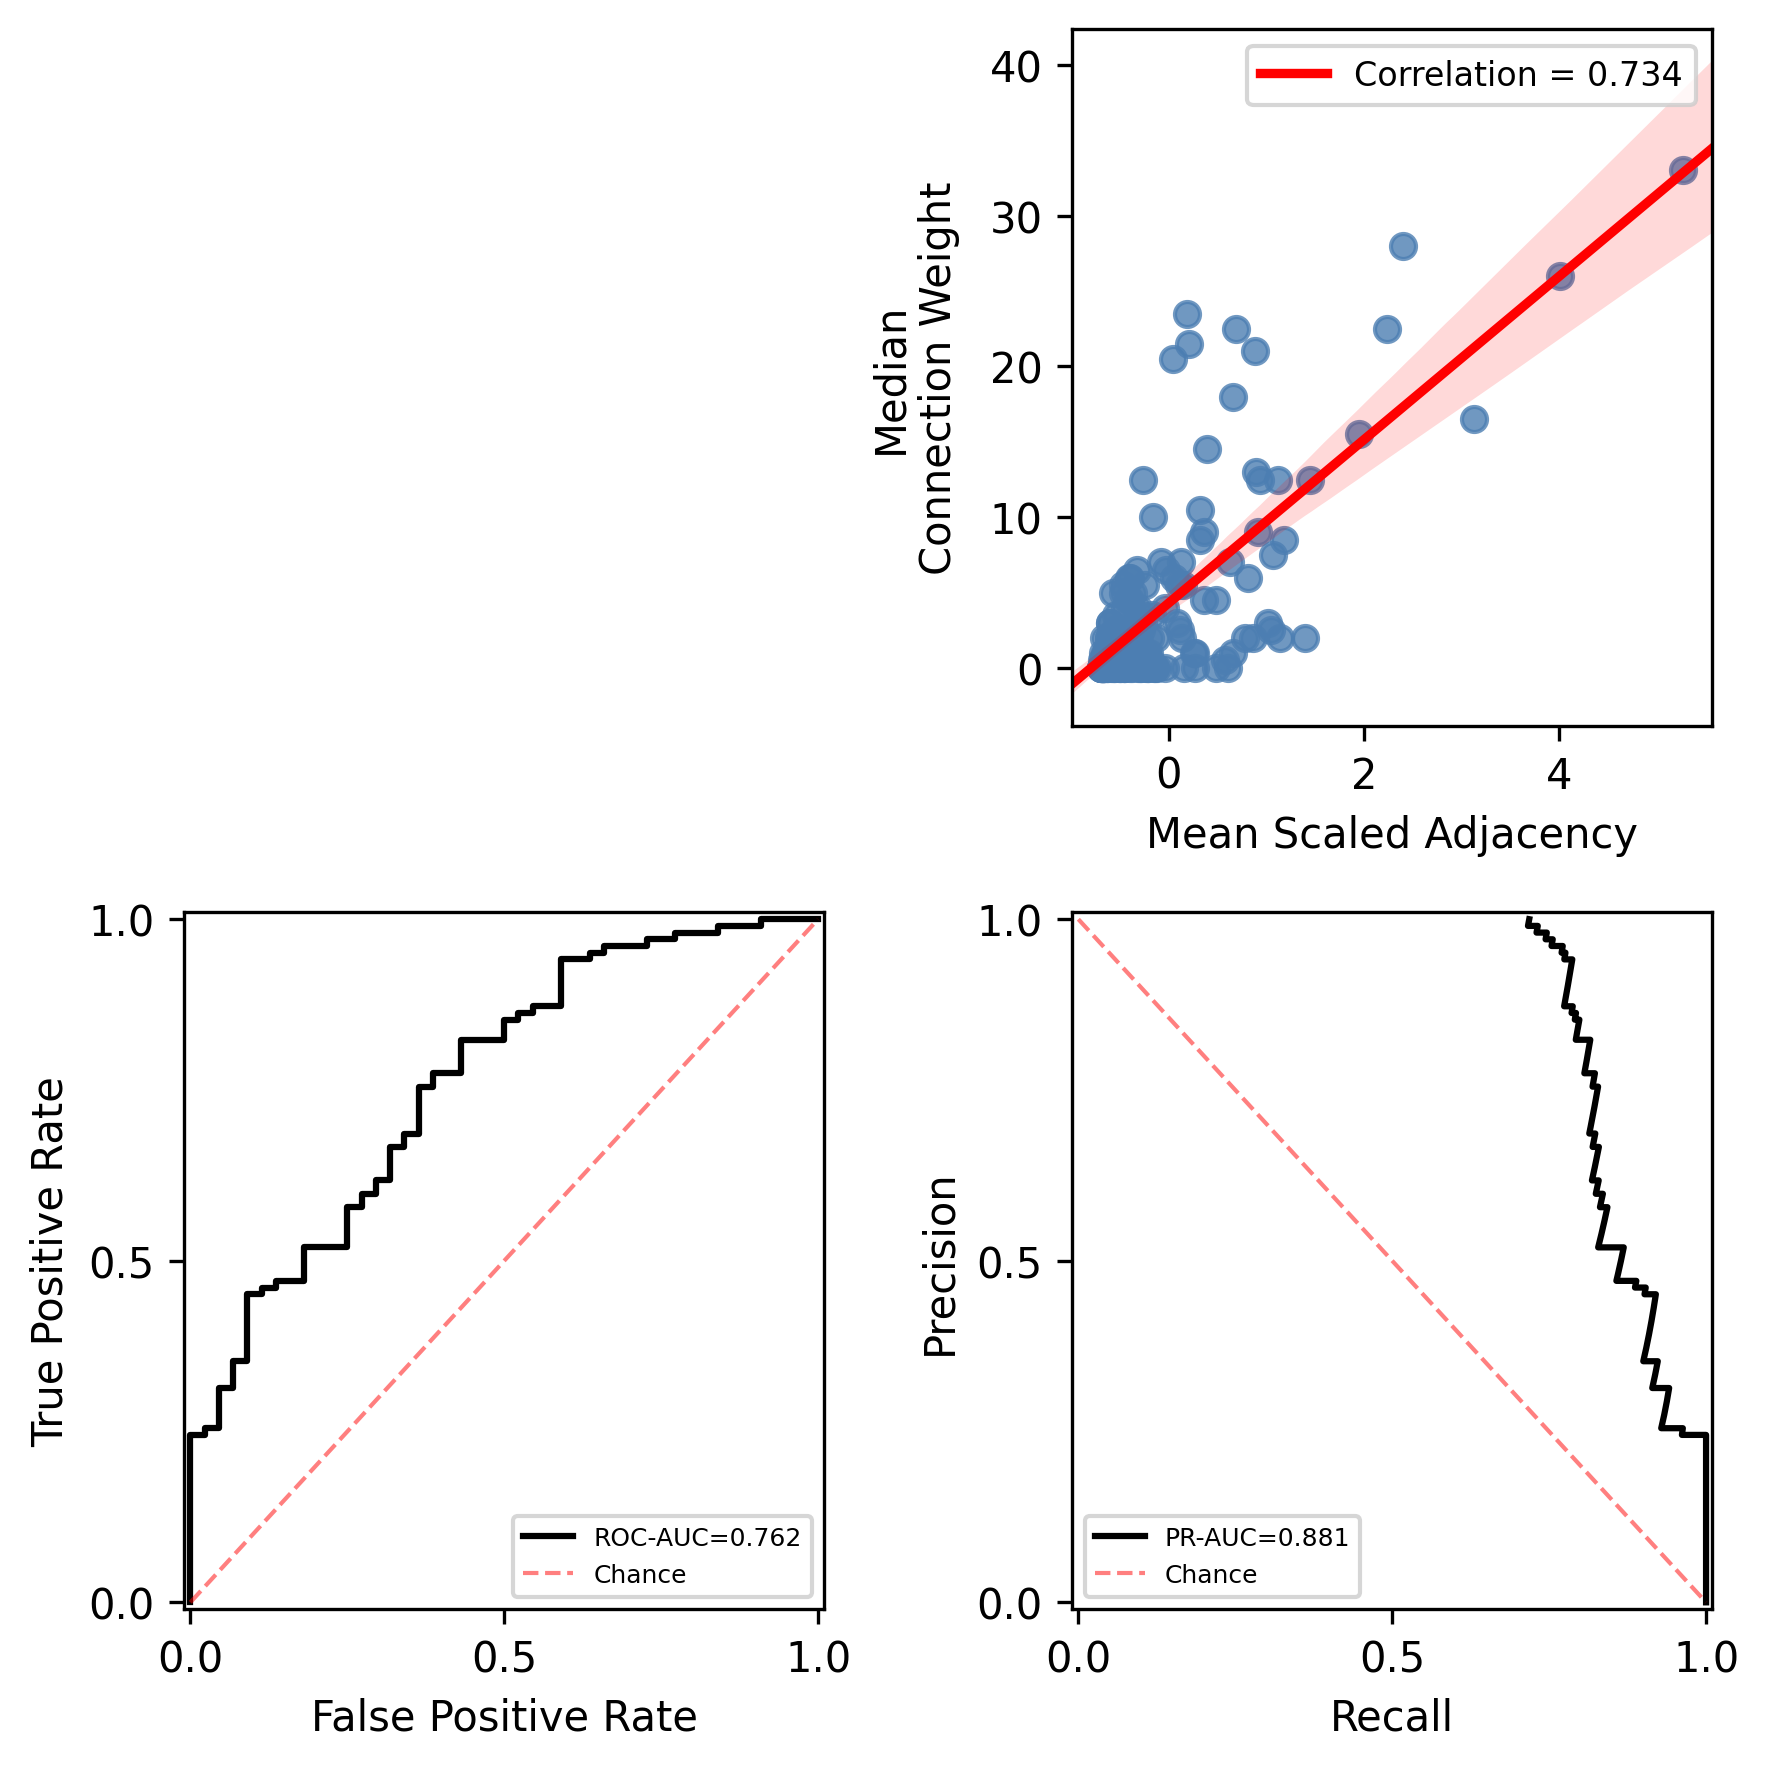

In [ ]:
#import dfs from the compare syn and edge cell##

def synapse_recode(X):
  if X >0:
    return 1
  else:
    return 0

DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency/input/'
os.chdir(DIRECTORY_CHOOSE)
adj, syn = pd.read_csv('df_merged_pharynx_adj_ml_full.csv'), pd.read_csv('df_merged_pharynx_syn_ml_full.csv')
df_merged_pharynx = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), [adj,syn])
new_cols = ['jsa_adj', 'n2w_adj', 'synaptic_weight']
df_merged_pharynx.rename(columns=dict(zip(df_merged_pharynx.columns[[3,4,8]], new_cols)),inplace=True)

#construct new columns to measure the average synaptic size. 
df_merged_pharynx['dummy_size'] = df_merged_pharynx['synaptic_weight'].apply(synapse_recode)



#droplist includes SAB because Moyle and Brittin don't analyze. It's not a NR neuron. If a neuron is in one of two datasets, it becomes unclassified in the other.

droplist = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct']
df_merged_pharynx = df_merged_pharynx[~df_merged_pharynx.pre.isin(droplist)]
df_merged_pharynx = df_merged_pharynx[~df_merged_pharynx.post.isin(droplist)]


#scale and rename the adjacency columns
scaler = StandardScaler()
new_cols1 = ['jsa_adj-s', 'n2w_adj-s']
df_scale = pd.DataFrame(scaler.fit_transform(df_merged_pharynx.iloc[:,3:5]))
df_scale.rename(columns=dict(zip(df_scale.columns[[0,1]], new_cols1)),inplace=True)
df_scale['ave_scaled_adjacency'] = df_scale[['jsa_adj-s', 'n2w_adj-s']].mean(axis=1)



#concatenate dfs
df_concat_pharynx = pd.concat([df_merged_pharynx, df_scale.set_index(df_merged_pharynx.index)], axis=1)
df_concat_pharynx['pre_brittin'] = df_concat_pharynx.apply(lambda x: brittin_layers(x['pre']), axis=1)
df_concat_pharynx['post_brittin'] = df_concat_pharynx.apply(lambda x: brittin_layers(x['post']), axis=1)
df_concat_pharynx['pre_moyle'] = df_concat_pharynx.apply(lambda x: moyle_layers(x['pre']), axis=1)
df_concat_pharynx['post_moyle'] = df_concat_pharynx.apply(lambda x: moyle_layers(x['post']), axis=1)
df_concat_pharynx['brittin_strata'] = df_concat_pharynx.apply(lambda x: ganglia_check(x['pre_brittin'], x['post_brittin']), axis=1)
df_concat_pharynx['moyle_strata'] = df_concat_pharynx.apply(lambda x: ganglia_check(x['pre_moyle'], x['post_moyle']), axis=1)
df_concat_pharynx.fillna(0, inplace=True) 


#make dummy columns for the categorical predictors
categorical_cols = ['pre_brittin', 'post_brittin', 'pre_moyle', 'post_moyle', 'brittin_strata', 'moyle_strata']
df_concat_pharynx[['brittin_bool_1', 'brittin_bool_2']] = 1,0
df_concat_pharynx.to_csv('pharynx_modeling.csv')

#set variables for modeling
X_scale_pharynx = df_concat_pharynx[['ave_scaled_adjacency', 'brittin_bool_1', 'brittin_bool_2']]
Y_pharynx = df_concat_pharynx.dummy_size
Y_pharynx.fillna(0, inplace=True)
Y_pharynx = Y_pharynx.astype('int')


# Y.hist(figsize=(12,8), bins=10)
# plt.show()

# matrix = X_scale.corr().round(2)
# sns.heatmap(matrix, annot=True)
# plt.show()


###correlations###



rho, pval = stats.spearmanr(df_concat_pharynx.ave_scaled_adjacency, df_concat_pharynx.average_size_y)
print("spearman's r for ave scaled adjacency and new_ave_synapse", rho, pval)

rho, pval = stats.pearsonr(df_concat_pharynx.ave_scaled_adjacency, df_concat_pharynx.average_size_y)
print("pearson's r for ave scaled adjacency and new_ave_synapse", rho, pval)





#test final model on the pharynx

full_predictions = logreg_final.predict(X_scale_pharynx)
print(classification_report(Y_pharynx,full_predictions))

y_pred_proba_p = logreg_final.predict_proba(X_scale_pharynx)[::,1]
fpr, tpr, threshold = metrics.roc_curve(Y_pharynx, y_pred_proba_p)
precision, recall, threshold = precision_recall_curve(Y_pharynx, y_pred_proba_p)
auc_ROC = str(metrics.roc_auc_score(Y_pharynx, y_pred_proba_p))[:5]
auc_precision_recall = str(metrics.auc(recall, precision))[:5]


plt.rcParams["font.family"] = "sans-serif"
fig3 = plt.figure(figsize=(6, 6))
fig3.set_dpi(300)


fig3ax1 = fig3.add_subplot(2,2,2)
# Create third axes, a combination of third and fourth cell
# two rows, two colums, combined third and fourth cell
#plt.annotate('ax3', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
corr_pharynx,_ = stats.pearsonr(df_concat_pharynx['ave_scaled_adjacency'], df_concat_pharynx['average_size_y'])
sns.regplot(ax=fig3ax1, x=df_concat_pharynx.ave_scaled_adjacency, y=df_concat_pharynx.average_size_y,  color="#4C7EB2", truncate=False, line_kws={"color": "red"})
fig3ax1.set_xlabel('Mean Scaled Adjacency')
fig3ax1.set_ylabel('Median\nConnection Weight')
fig3ax1.legend(labels=['Correlation = '+ str(corr_pharynx)[:5]], fontsize=8)

# sns.scatterplot(ax=fig3ax1, x=df_concat_pharynx.ave_scaled_adjacency, y=df_concat_pharynx.average_size_y, color="#4C7EB2", linewidth=0.1)
# fig3ax1.set_xlabel('Mean Scaled Adjacency')
# fig3ax1.set_ylabel('Median\nConnection Weight')
# fig3ax1.set_xlim([-1,6])
# fig3ax1.set_yticks([0,25,50])


# fig2ax2 = fig2.add_subplot(3,2,3)
# fig2ax2.scatter(df_concat.ave_scaled_adjacency, df_concat.dummy_size, s=5, edgecolor = "black", linewidth=0.2, color="#4C7EB2")
# fig2ax2.set_xlabel('Mean Scaled Adjacency')
# fig2ax2.set_ylabel('Binarized\nConnection Weight')
# fig2ax2.set_xlim([0,11])
# fig2ax2.set_yticks([0,1])

# fig3ax2 = fig3.add_subplot(2,2,2)
# sns.regplot(x=df_concat_pharynx.ave_scaled_adjacency, y=df_concat_pharynx.dummy_size, ax=fig3ax2, logistic=True, n_boot=500, y_jitter=0.03, line_kws={'color': 'black'}, scatter_kws={'edgecolor': 'white', 'color': '#4C7EB2', 'linewidth': 0.1})
# fig3ax2.set_xlabel('Mean Scaled Adjacency')
# fig3ax2.set_ylabel('Binarized\nConnection Weight')
# fig3ax2.set_xlim([-1,6])
# fig3ax2.set_ylim([-0.25,1.25])
# fig3ax2.set_yticks([0,1])





fig3ax3 = fig3.add_subplot(2,2,3)
# fig, (ax1, ax2) = plt.subplots(1, 2)
fig3ax3.plot(fpr,tpr,label="ROC-AUC="+str(auc_ROC), color='k')
fig3ax3.set_xlabel('False Positive Rate')
fig3ax3.set_ylabel('True Positive Rate')
fig3ax3.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig3ax3.legend(loc=4, prop={'size': 6})
fig3ax3.set_xlim([-0.01, 1.01])
fig3ax3.set_ylim([-0.01, 1.01])
fig3ax3.set_yticks([0,0.50,1.0])
fig3ax3.set_xticks([0,0.50,1.0])


fig3ax4 = fig3.add_subplot(2,2,4)


fig3ax4.plot(precision,recall,label="PR-AUC="+str(auc_precision_recall), color='k')
fig3ax4.set_xlabel('Recall')
fig3ax4.set_ylabel('Precision')
fig3ax4.plot([0, 1], [1, 0], linestyle='--', lw=1, color='r', label='Chance', alpha=.5)
fig3ax4.legend(loc=3, prop={'size': 6})
fig3ax4.set_xlim([-0.01, 1.01])
fig3ax4.set_ylim([-0.01, 1.01])
fig3ax4.set_yticks([0,0.50,1.0])
fig3ax4.set_xticks([0,0.50,1.0])



fig3.align_ylabels()
fig3.subplots_adjust(wspace=0.5, hspace=0.8) 
fig3.tight_layout()
plt.savefig("plos_comp_bio_fig3_pharynx.svg")
plt.show()







male comparion section

[0.01557632398753894, 0.031496062992125984, 0.04603580562659847, 0.022321428571428572, 0.027257240204429302, 0.024475524475524476, 0.08767471410419314, 0.056555269922879174, 0.07050359712230216, 0.16382978723404254, 0.11608623548922056]
individuality mean undirected 0.06016472633911667
aggregate individuality undirected 0.31275440976933516
%male connections that are adjacenct in the herm 0.8428571428571429
difference in adj conserved by male-specific status
male_only
0    6.179878
1    5.057143
Name: conserved_x, dtype: float64
difference in adj conserved and in the male
in_males
0    5.636059
1    7.935323
Name: conserved_x, dtype: float64
percent male only directed edges 0.0418622848200313
percent hermaprhodite only directed edges 0.5469483568075117
[0.09494949494949495, 0.20642857142857143, 0.022172949002217297, 0.025925925925925925, 0.045774647887323945, 0.020833333333333332, 0.036855036855036855, 0.026381909547738693, 0.09099018733273863, 0.06425339366515836, 0.12738095238095237]


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 48.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 80.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:339: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:352: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys

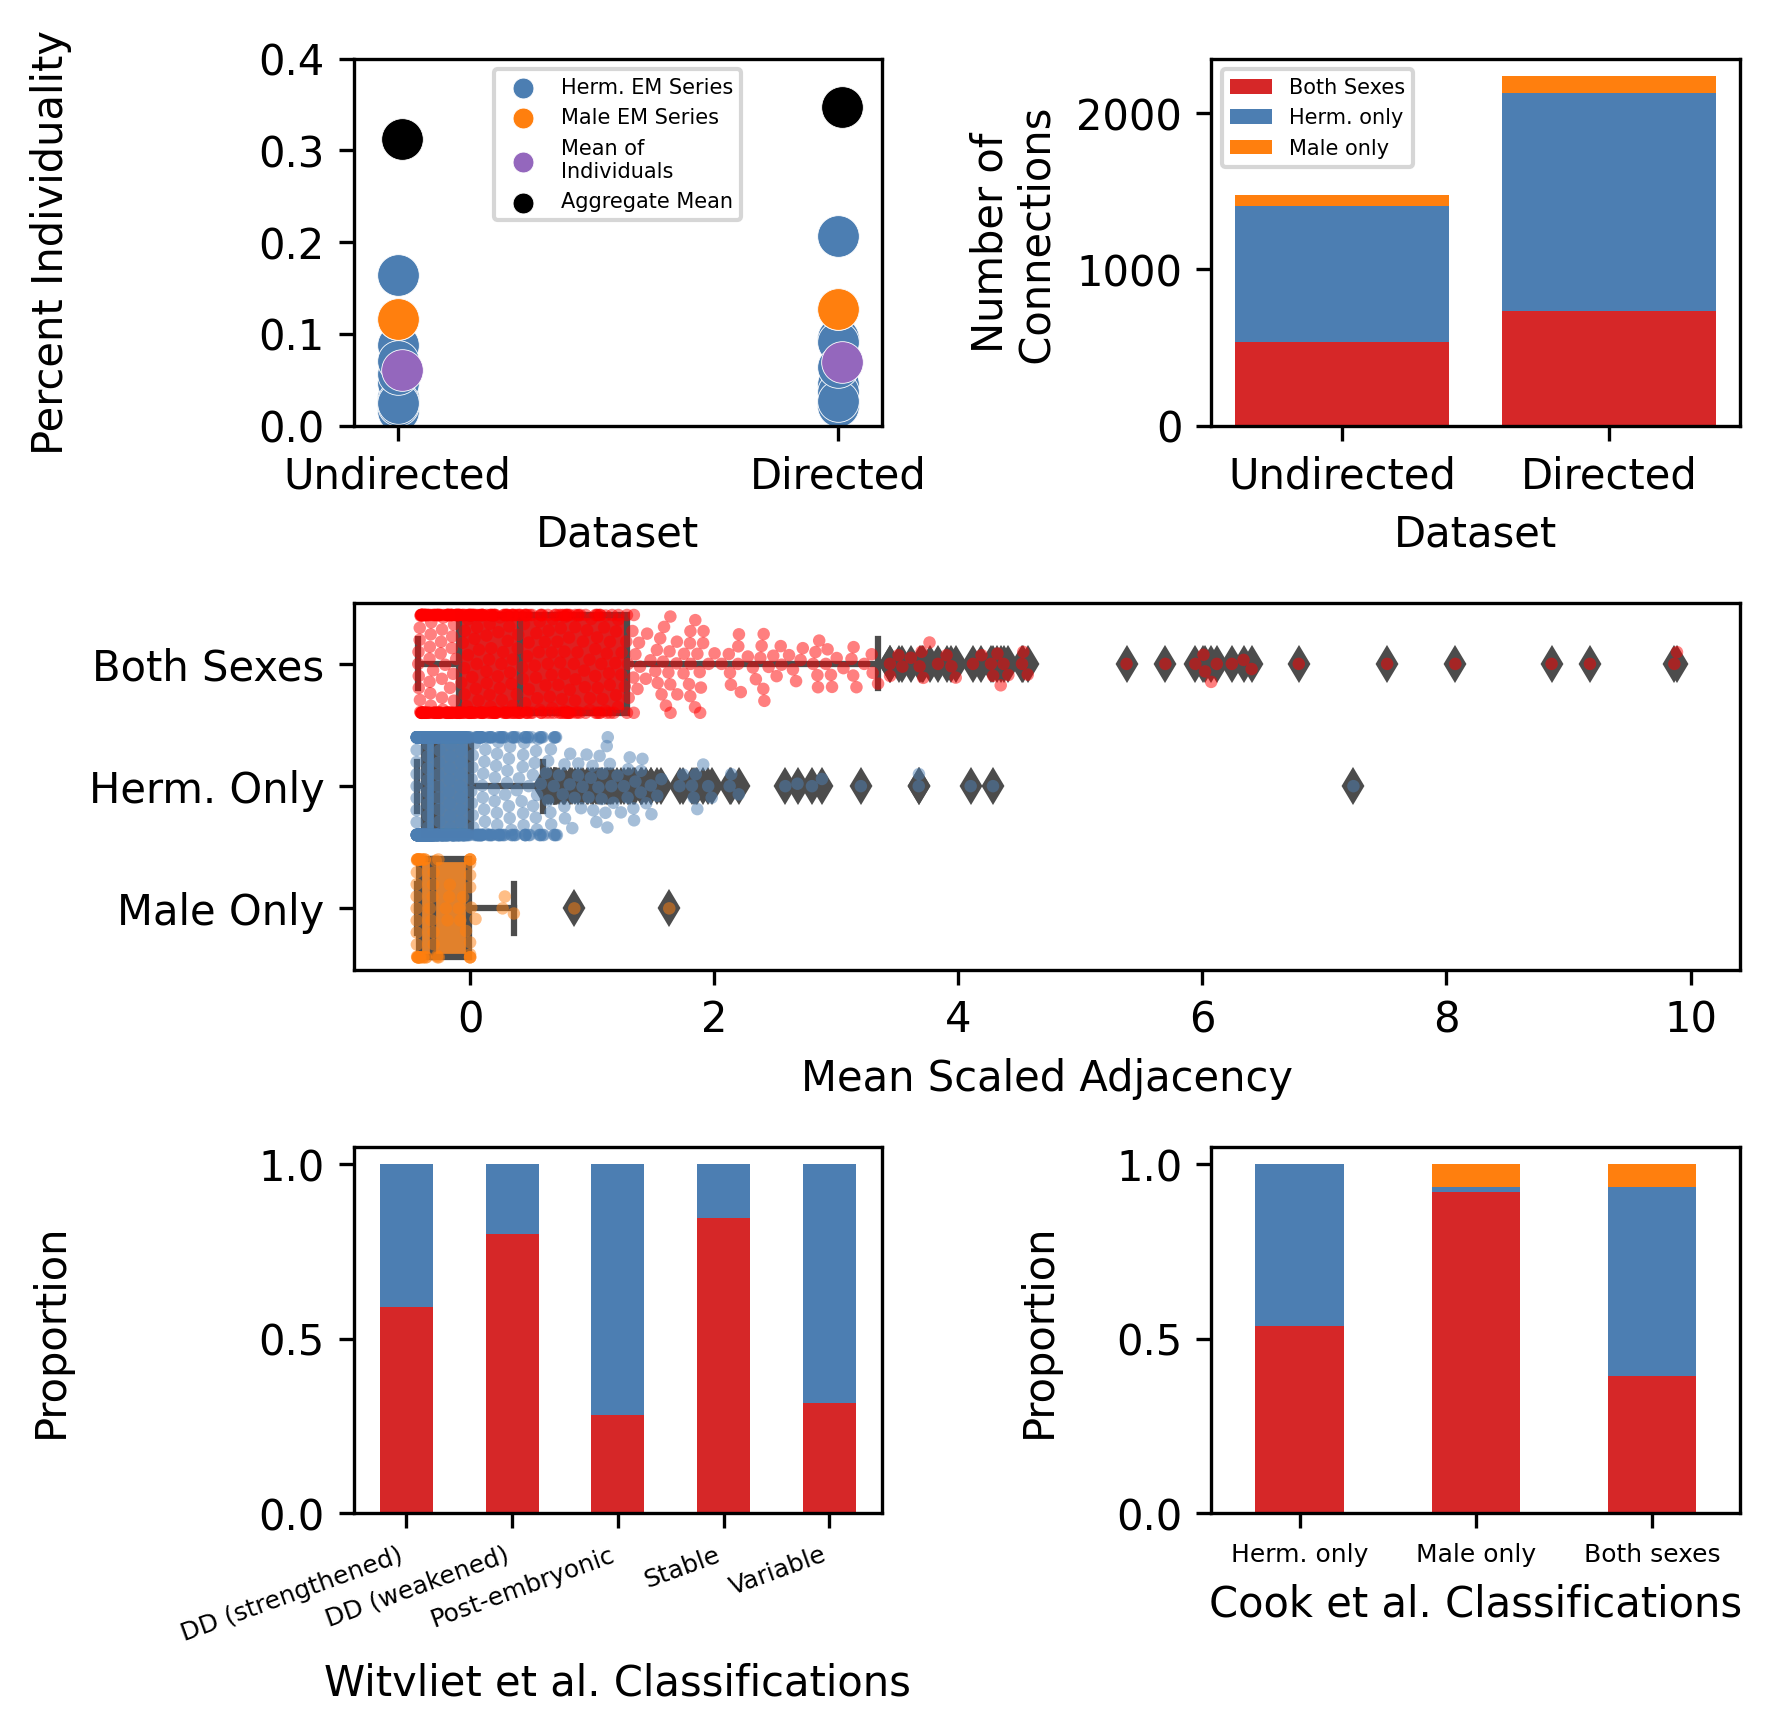

In [ ]:
from matplotlib_venn import venn3, venn2, venn3_circles
import matplotlib.pyplot as plt


DIRECTORY_CHOOSE = '/content/drive/MyDrive/cook_adjacency/input/male/'
os.chdir(DIRECTORY_CHOOSE)

def recode_sig(x):
    if x >= 2:
        return 'hermaphrodite-specific'
    elif x <= -2:
        return 'male-specific'
    else:
        return 'non-specific'



#recode function for how to deal with average synaptic size. 

def synapse_recode(X):
  if X > 0:
    return 1
  else:
    return 0

#import dfs from the compare syn and edge cell##

#change to male
male, NR_modeling = pd.read_csv('n930_head1.csv'), pd.read_csv('NR_modeling.csv')
male['pre']=male['pre'].apply(str)
male['post']=male['post'].apply(str)
male['pre'] = male.apply(lambda x: nclass_strata(x['pre']), axis=1)
male['post'] = male.apply(lambda x: nclass_strata(x['post']), axis=1)
male[['pre','post']] = np.sort(male[['pre', 'post']])[:, ::1]
malegroup = male.groupby(['pre','post'], as_index=False)['weight'].sum()

droplist_male = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct', 'CEPsh', 'GLR']


malegroup = malegroup[~malegroup.pre.isin(droplist_male)]
malegroup = malegroup[~malegroup.post.isin(droplist_male)]


male_merged = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='outer'), [NR_modeling,malegroup])
male_merged.fillna(0, inplace=True) 
male_merged['n930_syn'] = male_merged['weight']


male_merged['male_only'] = np.where((male_merged.conserved_y==0) & (male_merged.n930_syn > 0), 1, 0)
male_merged['herm_only'] = np.where((male_merged.conserved_y > 0) & (male_merged.n930_syn == 0), 1, 0)
male_merged['both_sexes'] = np.where((male_merged.conserved_y > 0) & (male_merged.n930_syn > 0), 1, 0)
male_merged['in_males'] = np.where(male_merged.n930_syn > 0, 1, 0)
male_merged['total_syn_conservation'] = male_merged['conserved_y'] + male_merged['in_males']
individual_syn_only = male_merged[male_merged['total_syn_conservation'] == 1]


#generate individuality values
individuality_list =  ['witvliet_1_syn', 'witvliet_2_syn', 'witvliet_3_syn', 'witvliet_4_syn', 'witvliet_5_syn', 'witvliet_6_syn', 'witvliet_7_syn', 'witvliet_8_syn', 'jsh_syn', 'n2u_syn', 'n930_syn']
individuality_values = []
for i in individuality_list:
  syn_col = i
  value = len(individual_syn_only[individual_syn_only[syn_col] > 0]) / len(male_merged[male_merged[syn_col] > 0])
  individuality_values.append(value)



print(individuality_values)
individuality_mean = np.mean(individuality_values)
print('individuality mean undirected', individuality_mean)
aggregrate_individuality = len(male_merged[male_merged['total_syn_conservation'] == 1]) / len(male_merged[male_merged['total_syn_conservation'] > 0])
print('aggregate individuality undirected', aggregrate_individuality)





#how many male connections are herm adjacencies
male_merged['male_specific_and_adj'] = np.where((male_merged.male_only==1) & (male_merged.conserved_x > 0), 1, 0)
male_specific_has_adjacency = len(male_merged[male_merged['male_specific_and_adj'] == 1]) / len(male_merged[male_merged['male_only'] ==1])
print('%male connections that are adjacenct in the herm', male_specific_has_adjacency)


print('difference in adj conserved by male-specific status')
print(male_merged.groupby('male_only')['conserved_x'].mean())


print('difference in adj conserved and in the male')
print(male_merged.groupby('in_males')['conserved_x'].mean())


male_merged.to_csv('maletest.csv')





#grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)







df_zscore, full_syn, classification = pd.read_csv("zscores.csv", sep=','), pd.read_csv("df_merged_adult_syn_male_DIRECTED.csv"), pd.read_csv('witvliet_classification.csv')
classification['pre'] = classification.apply(lambda x: nclass_strata(x['pre']), axis=1)
classification['post'] = classification.apply(lambda x: nclass_strata(x['post']), axis=1)
#df_zscore['pre'] = df_zscore.apply(lambda x: nclass_strata(x['pre']), axis=1)
#df_zscore['post'] = df_zscore.apply(lambda x: nclass_strata(x['post']), axis=1)
classification.drop_duplicates(keep='first', inplace=True)
male_merged_directed1 = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='outer'), [full_syn, df_zscore])
male_merged_directed = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), [male_merged_directed1, classification])
male_merged_directed['significance'] = male_merged_directed.apply(lambda x: recode_sig(x['Z']), axis=1)
male_merged_directed['Z_abs'] = abs(male_merged_directed.Z)

herm = male_merged_directed.filter(regex=("witv.*|cel.*"))
male = male_merged_directed.filter(regex=("n930*"))

droplist = ['unk', 'BWM', 'VA01', 'VB01', 'VB02', 'VC01', 'VD01', 'SAB', 'CAN', 'unknownFLPR', 'PVD', 'HSN', 'VA', 'VB', 'VD', 
            'Fragment1', 'Fragment2', 'Fragment3', 'Fragment4', 'excgl', 'DB', 'DA', 'excduct', 'CEPsh', 'MNVC', 'hyp', 'AS09',
            'vBWM', 'mu_int', 'MUBODY', 'MUHEAD', 'AS10', 'exc_gl', 'DA08', 'VA11', 'VA12', 'AS11', 'VA09', 'VA10', 'vBWWM', 'VD13']
male_merged_directed = male_merged_directed[~male_merged_directed.pre.isin(droplist)]
male_merged_directed = male_merged_directed[~male_merged_directed.post.isin(droplist)]

new_cols = ['cel_jsh', 'cel_n2u', 'n930', 'witvliet_1', 'witvliet_2', 'witvliet_3', 'witvliet_4', 'witvliet_5', 'witvliet_6', 'witvliet_7', 'witvliet_8']
male_merged_directed.rename(columns=dict(zip(male_merged_directed.columns[[3,4,5,6,7,8,9,10,11,12,13]], new_cols)),inplace=True)
male_merged_directed['male_only'] = np.where((male_merged_directed.n930 > 0) & (male_merged_directed.conserved == 1), 1, 0)
male_merged_directed['herm_only'] = np.where((male_merged_directed.n930 == 0) & (male_merged_directed.conserved >= 1), 1, 0)
male_merged_directed['both_sexes'] = np.where((male_merged_directed.n930 > 0) & (male_merged_directed.conserved > 1), 1, 0)
individual_syn_only_directed = male_merged_directed[male_merged_directed['conserved'] == 1]



male_merged_directed.fillna(0, inplace=True) 
male_merged_directed.to_csv('male_directed.csv')

percent_male_only = len(male_merged_directed[male_merged_directed['male_only'] > 0]) / len(male_merged_directed[male_merged_directed['male_only'] >= 0])
print('percent male only directed edges', percent_male_only)


percent_male_only = len(male_merged_directed[male_merged_directed['herm_only'] > 0]) / len(male_merged_directed[male_merged_directed['herm_only'] >= 0])
print('percent hermaprhodite only directed edges', percent_male_only)

individuality_list_directed =  ['cel_jsh', 'cel_n2u', 'witvliet_1', 'witvliet_2', 'witvliet_3', 'witvliet_4', 'witvliet_5', 'witvliet_6', 'witvliet_7', 'witvliet_8', 'n930']
individuality_values_directed = []
for i in individuality_list_directed:
  syn_col = i
  value = len(individual_syn_only_directed[individual_syn_only_directed[syn_col] > 0]) / len(male_merged_directed[male_merged_directed[syn_col] > 0])
  individuality_values_directed.append(value)


print(individuality_values_directed)
individuality_mean_directed = np.mean(individuality_values_directed)
print('individuality mean directed', individuality_mean_directed)
aggregrate_individuality_directed = len(male_merged_directed[male_merged_directed['conserved'] == 1]) / len(male_merged_directed[male_merged_directed['conserved'] > 0])
print('aggergate individuality directed', aggregrate_individuality_directed)



#venn diagram calculations

venn_herm_only = len(male_merged[male_merged['herm_only'] == 1])
venn_male_only = len(male_merged[male_merged['male_only'] == 1])
venn_both = len(male_merged[male_merged['both_sexes'] == 1])
print('herm only', venn_herm_only, 'male only', venn_male_only, 'both', venn_both)

venn_herm_only_directed = len(male_merged_directed[male_merged_directed['herm_only'] == 1])
venn_male_only_directed = len(male_merged_directed[male_merged_directed['male_only'] == 1])
venn_both_directed = len(male_merged_directed[male_merged_directed['both_sexes'] == 1])

stacked_x = ['Undirected', 'Directed']
stacked_y1 = np.array([venn_both, venn_both_directed])
stacked_y2 = np.array([venn_herm_only, venn_herm_only_directed])
stacked_y3 = np.array([venn_male_only, venn_male_only_directed])


# fig4= plt.figure(figsize=(6, 6))
# #fig.set_size_inches(4, 3)

# fig4.set_dpi(300)
# #plt.subplots_adjust(wspace= 0.25, hspace= 0.25)


# fig4ax1 = fig4.add_subplot(grid[:2,0]) # two rows, two columns, second cell
# #plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
# x = np.zeros_like(individuality_values)
# fig4ax1.scatter(x,individuality_values, label = 'Herm. EM Series', edgecolor='w', linewidth=0.2, s=100, c="#4C7EB2")
# fig4ax1.scatter(0.0,individuality_values[10], label = 'Male EM Series', c='tab:orange', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(0.01,individuality_mean, label = 'Mean ='+str(individuality_mean)[:5], c='r', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(0.01,aggregrate_individuality, label = 'Aggregate='+str(aggregrate_individuality)[:5], c='k', edgecolor='w', linewidth=0.2, s=100)
# # fig4ax1.scatter(0.01,individuality_mean, label = 'Mean ='+str(individuality_mean)[:5], c='r', edgecolor='w', linewidth=0.2, s=100)
# # fig4ax1.scatter(0.01,aggregrate_individuality, label = 'Aggregate='+str(aggregrate_individuality)[:5], c='k', edgecolor='w', linewidth=0.2, s=100)
# x_directed = np.ones_like(individuality_values)
# fig4ax1.scatter(x_directed,individuality_values_directed, edgecolor='w', linewidth=0.2, s=100, c="#4C7EB2")
# fig4ax1.scatter(1.0,individuality_values_directed[10], c='tab:orange', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(1.01,individuality_mean_directed, label = 'Mean  \n(Directed) ='+str(individuality_mean_directed)[:5], c='r', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(1.01,aggregrate_individuality_directed, label = 'Aggregate  \n(Directed)='+str(aggregrate_individuality_directed)[:5], c='k', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.set_ylim([0,0.4])
# fig4ax1.set_xlim([-0.1,1.1])
# fig4ax1.set_xlabel('Dataset')
# fig4ax1.set_xticks([0,1])
# fig4ax1.set_xticklabels(['Undirected', 'Directed'])
# fig4ax1.set_ylabel('Percent Individuality')
# fig4ax1.legend(loc="upper center", markerscale=0.5, prop={'size': 5})


# fig4ax2 = fig4.add_subplot(grid[0,1])
# fig4ax2 = venn2(subsets = (venn_herm_only, venn_male_only, venn_both), set_labels = ('Hermaphrodite only', 'Male only'), set_colors=("#4C7EB2", 'tab:orange'), alpha=0.7)


# fig4ax3 = fig4.add_subplot(grid[1,1])
# fig4ax3 = venn2(subsets = (venn_herm_only_directed, venn_male_only_directed, venn_both_directed), set_labels = ('Hermaphrodite only', 'Male only'), set_colors=("#4C7EB2", 'tab:orange'), alpha=0.7)





# fig4ax4 = fig4.add_subplot(grid[2,0:])
# dfmelt = pd.melt(male_merged, id_vars=['male_only'], value_vars=['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S'])
# dfmelt2 = pd.melt(male_merged, id_vars=['male_only'], value_vars=['ave_scaled_adjacency'])

# means = dfmelt.groupby(['variable','male_only'])['value'].mean().reset_index()


# order_list = ['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S']
# sns.violinplot(data=dfmelt, ax=fig4ax4, y='variable', x='value', hue='male_only', inner=None, linewidth=1, saturation=1, dodge=True, color='#DDDDDD', order=order_list)
# sns.stripplot(data=dfmelt, ax=fig4ax4, y='variable', x='value', hue='male_only', linewidth=1, jitter=True, dodge=True, alpha=0.7, size=2, order=order_list)
# sns.stripplot(ax=fig4ax4, x='value', y='variable', data=means, hue='male_only', edgecolor='red', linewidth=1, size=4, jitter=False, dodge=True, order=order_list)
# fig4ax4.set_yticklabels(['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult'])
# fig4ax4.set_xlabel('Mean Scaled Adjacency')
# fig4ax4.set_ylabel('EM Series')
# fig4ax4.get_legend().remove()







# fig4.align_ylabels()
# fig4.suptitle('')
# fig4.subplots_adjust(wspace=0.5, hspace=0.8) 
# fig4.tight_layout()
# plt.savefig("plos_comp_bio_fig4_male.svg")
# plt.show()


fig4= plt.figure(figsize=(6, 6))
#fig.set_size_inches(4, 3)

fig4.set_dpi(300)
#plt.subplots_adjust(wspace= 0.25, hspace= 0.25)


fig4ax1 = fig4.add_subplot(3,2,1) # two rows, two columns, second cell
#plt.annotate('ax2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
x = np.zeros_like(individuality_values)
fig4ax1.scatter(x,individuality_values, label = 'Herm. EM Series', edgecolor='w', linewidth=0.2, s=100, c="#4C7EB2")
fig4ax1.scatter(0.0,individuality_values[10], label = 'Male EM Series', c='tab:orange', edgecolor='w', linewidth=0.2, s=100)
fig4ax1.scatter(0.01,individuality_mean, label = 'Mean of \nIndividuals', c='tab:purple', edgecolor='w', linewidth=0.2, s=100)
fig4ax1.scatter(0.01,aggregrate_individuality, label = 'Aggregate Mean', c='k', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(0.01,individuality_mean, label = 'Mean ='+str(individuality_mean)[:5], c='r', edgecolor='w', linewidth=0.2, s=100)
# fig4ax1.scatter(0.01,aggregrate_individuality, label = 'Aggregate='+str(aggregrate_individuality)[:5], c='k', edgecolor='w', linewidth=0.2, s=100)
x_directed = np.ones_like(individuality_values)
fig4ax1.scatter(x_directed,individuality_values_directed, edgecolor='w', linewidth=0.2, s=100, c="#4C7EB2")
fig4ax1.scatter(1.0,individuality_values_directed[10], c='tab:orange', edgecolor='w', linewidth=0.2, s=100)
fig4ax1.scatter(1.01,individuality_mean_directed, c='tab:purple', edgecolor='w', linewidth=0.2, s=100)
fig4ax1.scatter(1.01,aggregrate_individuality_directed, c='k', edgecolor='w', linewidth=0.2, s=100)
fig4ax1.set_ylim([0,0.4])
fig4ax1.set_xlim([-0.1,1.1])
fig4ax1.set_xlabel('Dataset')
fig4ax1.set_xticks([0,1])
fig4ax1.set_xticklabels(['Undirected', 'Directed'])
fig4ax1.set_ylabel('Percent Individuality')
fig4ax1.legend(loc="upper center", markerscale=0.5, prop={'size': 5})


fig4ax2 = fig4.add_subplot(3,2,2)
fig4ax2.bar(stacked_x, stacked_y1, color='tab:red', label='Both Sexes')
fig4ax2.bar(stacked_x, stacked_y2, bottom=stacked_y1, color='#4C7EB2', label='Herm. only')
fig4ax2.bar(stacked_x, stacked_y3, bottom=stacked_y1+stacked_y2, color='tab:orange', label='Male only')
fig4ax2.set_xlabel('Dataset')
fig4ax2.set_ylabel('Number of\n Connections')
fig4ax2.legend(loc="upper left", markerscale=0.5, prop={'size': 5})



fig4ax3 = fig4.add_subplot(3,2,(3,4))
# dfmelt = pd.melt(male_merged, id_vars=['male_only'], value_vars=['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S'])
# dfmelt2 = pd.melt(male_merged, id_vars=['male_only'], value_vars=['ave_scaled_adjacency'])
# dfmelt3 = pd.melt(male_merged, id_vars=['male_only', 'herm_only', 'both_sexes'], value_vars=['ave_scaled_adjacency'])

df3 = male_merged
conditions = [(df3['both_sexes'] == 1),(df3['herm_only']==1), (df3['male_only'] == 1)]
values = ['both_sexes', 'herm_only', 'male_only']
df3['sex'] = np.select(conditions, values)
df3['sex'].unique()
df3 = df3[df3.sex != '0']
my_pal = {"both_sexes": "red", "herm_only": "#4C7EB2", "male_only":"tab:orange"}
sns.boxplot(ax=fig4ax3, data = df3, y = 'sex', x='ave_scaled_adjacency', palette = my_pal, order=['both_sexes', 'herm_only', 'male_only'])
sns.swarmplot(ax=fig4ax3, data = df3, y = 'sex', x='ave_scaled_adjacency',  palette = my_pal, size=3, alpha=0.5, order=['both_sexes', 'herm_only', 'male_only'])
fig4ax3.set_yticklabels(['Both Sexes','Herm. Only','Male Only'])
fig4ax3.set_xlabel('Mean Scaled Adjacency')
fig4ax3.set_ylabel('')



# order_list = ['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S']
# sns.violinplot(data=dfmelt, ax=fig4ax3, y='variable', x='value', hue='male_only', inner=None, linewidth=1, saturation=1, dodge=True, color='#DDDDDD', order=order_list)
# sns.stripplot(data=dfmelt, ax=fig4ax3, y='variable', x='value', hue='male_only', linewidth=1, jitter=True, dodge=True, alpha=0.7, size=2, order=order_list)
# sns.stripplot(ax=fig4ax3, x='value', y='variable', data=means, hue='male_only', edgecolor='k',  linewidth=1, size=4, jitter=False, dodge=True, order=order_list)
# fig4ax3.set_yticklabels(['L1-1', 'L1-2', 'L1-3', 'L1-4', 'L2', 'L3', 'L4-JSH', 'Adult-N2U', 'Adult'])
# fig4ax3.set_xlabel('Mean Scaled Adjacency')
# fig4ax3.set_ylabel('EM Series')
# handles, labels = fig4ax3.get_legend_handles_labels()
# # labels[2:4] = ['Herm Only', 'Male Only']
# fig4ax3.legend(handles[2:4], labels[2:4])



# handles,labels = p.get_legend_handles_labels()
# #for h in handles:
# #    h.set_height(3)
# #handles[2].set_linewidth(33)

# plt.legend(handles[2:],
#            labels[2:],
#            bbox_to_anchor = (.3,.95),
#            fontsize = 40,
#            markerscale = 5,
#            frameon=False,
#            labelspacing=0.2)




fig4ax4 = fig4.add_subplot(3,2,(5))
male_merged_directed_nozeroclass = male_merged_directed[male_merged_directed['classification'] != 0]
classtable = male_merged_directed_nozeroclass.groupby(['classification'])['both_sexes','herm_only','male_only'].sum()
classtable_prop = classtable.div(classtable.sum(axis=1), axis = 0)
classtable_prop.plot(kind="bar", ax=fig4ax4, stacked = True, color=['tab:red', '#4C7EB2', 'tab:orange'], legend=None)
fig4ax4.set_xticklabels(['DD (strengthened)', 'DD (weakened)', 'Post-embryonic', 'Stable', 'Variable'])
plt.xticks(rotation = 20, fontsize=6, ha="right")
fig4ax4.set_xlabel('Witvliet et al. Classifications')
fig4ax4.set_ylabel('Proportion')
fig4ax4.set_title('')
classtable.to_csv('classification_table.csv')


fig4ax5 = fig4.add_subplot(3,2,(6))
male_merged_directed_nozerosig = male_merged_directed[male_merged_directed['Z_abs'] != 0]
dfmelt7 = male_merged_directed_nozerosig.groupby(['significance'])['both_sexes','herm_only','male_only'].sum()
dfmelt7_prop = dfmelt7.div(dfmelt7.sum(axis=1), axis = 0)
dfmelt7_prop.plot(kind="bar", ax=fig4ax5, stacked = True, color=['tab:red', '#4C7EB2', 'tab:orange'], legend=None)
fig4ax5.set_xticklabels(['Herm. only', 'Male only', 'Both sexes'])
plt.xticks(rotation = 'horizontal', fontsize=6, ha = 'center')
fig4ax5.set_xlabel('Cook et al. Classifications')
fig4ax5.set_ylabel('Proportion')
fig4ax5.set_title('')
dfmelt7.to_csv('significance_table.csv')


#dfmelt6 = pd.melt(male_merged_directed_nozero, id_vars=['significance'], value_vars=['male_only','herm_only', 'both_sexes'])

# sns.barplot(ax=fig4ax4, data=dfmelt6, x='significance', y='value', hue='variable', ci=0)
# sns.move_legend(fig4ax4, "upper center", title='Conserved', fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)




# dfmelt3 = pd.melt(male_merged, id_vars=['male_only', 'herm_only', 'both_sexes'], value_vars=['witvliet_1_adj-S', 'witvliet_2_adj-S', 'witvliet_3_adj-S', 'witvliet_4_adj-S', 'witvliet_5_adj-S', 'witvliet_6_adj-S', 'jsh_adj-S', 'n2u_adj-S', 'witvliet_8_adj-S'])
# dfmelt4 = pd.melt(male_merged_directed, id_vars=['male_only', 'herm_only', 'both_sexes', 'Z_abs', 'classification'], value_vars=['witvliet_1', 'witvliet_2', 'witvliet_3', 'witvliet_4', 'witvliet_5', 'witvliet_6', 'cel_jsh', 'cel_n2u', 'witvliet_8'])

# print(dfmelt4)
# sns.stripplot(data=dfmelt4, ax=fig4ax4, y='variable', x='value', hue='classification', linewidth=1, jitter=True, dodge=True, alpha=0.7, size=2)
# sns.move_legend(fig4ax4, "upper right", title='Conserved', ncol=2, fontsize=4, title_fontsize=5,  labelspacing=0.3, handlelength=1)


##RECODE THE SEX SPECIFICITY INTO A SINGLE COLUMN##
##think about how to plot classification on y axis##


fig4.align_ylabels()
fig4.suptitle('')
fig4.subplots_adjust(wspace=0.5, hspace=0.8) 
fig4.tight_layout()
plt.savefig("plos_comp_bio_fig4_male.svg")
plt.show()







# df_concat = pd.concat([df_merged, df_scale.set_index(df_merged.index)], axis=1)
# df_concat['pre_brittin'] = df_concat.apply(lambda x: brittin_layers(x['pre']), axis=1)
# df_concat['post_brittin'] = df_concat.apply(lambda x: brittin_layers(x['post']), axis=1)
# df_concat['pre_moyle'] = df_concat.apply(lambda x: moyle_layers(x['pre']), axis=1)
# df_concat['post_moyle'] = df_concat.apply(lambda x: moyle_layers(x['post']), axis=1)
# df_concat['brittin_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_brittin'], x['post_brittin']), axis=1)
# df_concat['moyle_strata'] = df_concat.apply(lambda x: ganglia_check(x['pre_moyle'], x['post_moyle']), axis=1)

# #make dummy columns for the categorical predictors
# categorical_cols = ['pre_brittin', 'post_brittin', 'pre_moyle', 'post_moyle', 'brittin_strata', 'moyle_strata']
# df_concat[['brittin_bool_1', 'brittin_bool_2']] = pd.get_dummies(df_concat.brittin_strata, prefix='brittin')
# df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
# df_concat[['moyle_bool_1', 'moyle_bool_2']] = pd.get_dummies(df_concat.moyle_strata, prefix='moyle')
# df_concat[['brittin_pre_class_1', 'brittin_pre_class_2', 'brittin_pre_class_3', 'brittin_pre_class_4', 'brittin_pre_class_5', 'brittin_pre_class_6']] = pd.get_dummies(df_concat.pre_brittin, prefix='brittin')
# df_concat[['brittin_post_class_1', 'brittin_post_class_2', 'brittin_post_class_3', 'brittin_post_class_4', 'brittin_post_class_5', 'brittin_post_class_6']] = pd.get_dummies(df_concat.post_brittin, prefix='moyle')
# df_concat.fillna(0, inplace=True) 

# df_concat.to_csv('NR_modeling.csv')


# #set variables for modeling
# X_scale= df_concat[['ave_scaled_adjacency', 'brittin_bool_1', 'brittin_bool_2']]
# Y = df_concat.dummy_size
# Y.fillna(0, inplace=True)
# Y = Y.astype('int')

# #Takes input from previously run full

# n930 = pd.read_csv("cel_n930_chemical_male.csv", sep=',')
# droplist = ['MUHEAD', 'M' ]

# full = pd.read_csv("NR_modeling.csv", sep=',')
# dataframes = [n930, full]
# df_merged_sex = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), dataframes)
# df_merged_sex.fillna(0, inplace=True) 
# df_merged_sex.to_csv('test.csv')







# dataframes = [df_sex, df_zscore, df_witvliet_class]


# df_merged_sex = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), dataframes)
# df_merged_sex['significance'] = df_merged_sex.apply(lambda x: recode_sig(x['Z']), axis=1)
# df_merged_sex['Z_abs'] = abs(df_merged_sex.Z)

# df_merged_sex.columns.values[12] = "n930_male"
# herm = df_merged_sex.filter(regex=("witv.*|cel.*"))
# male = df_merged_sex.filter(regex=("n930*"))
# df_merged_sex["herm_sum"] = (herm.filter(like="weight",axis=1)!=0).sum(1)
# df_merged_sex['male_only'] = np.where((df_merged_sex.herm_sum==0) & (df_merged_sex.n930_male >0), "yes", "no")
# df_merged_sex['head_neuron'] = df_merged_sex['pre'].isin(class_list_head_neurons) & df_merged_sex['post'].isin(class_list_head_neurons)
# df_merged_sex.drop(columns = ['pristi_sum', 'elegans_sum', 'in_pristi', 'pristi_specific'], axis=1, inplace=True)

# #dataframes1 = [df_merged_sex, df_witvliet_class]

# #df_merged_sex1 = reduce(lambda  left,right: pd.merge(left,right,on=['pre','post'], how='left'), dataframes1)



# display(df_merged_sex)

# df_merged_sex.to_csv('sex_merged.csv', na_rep = 'NA')
